In [2]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)          # or a big number like 2000
pd.set_option('display.expand_frame_repr', False)

In [4]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = 'US_Accidents_March23.csv'

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sobhanmoosavi/us-accidents",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/var/folders/13/cpzkkz6x5v928nvbv6mzqqgw0000gn/T/ipykernel_64492/1350048045.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:     ID   Source  Severity           Start_Time             End_Time  Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)                                        Description                     Street          City      County State     Zipcode Country    Timezone Airport_Code    Weather_Timestamp  Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  Visibility(mi) Wind_Direction  Wind_Speed(mph)  Precipitation(in) Weather_Condition  Amenity   Bump  Crossing  Give_Way  Junction  No_Exit  Railway  Roundabout  Station   Stop  Traffic_Calming  Traffic_Signal  Turning_Loop Sunrise_Sunset Civil_Twilight Nautical_Twilight Astronomical_Twilight
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00  39.865147 -84.058723      NaN      NaN          0.01  Right lane blocked due to accident on I-70 Eas...                     I-70 E        Dayton  Montgomery    OH       45424      US  US/Eastern         KFFO  2016-02-08 05:58:00            36.9            NaN     

In [5]:
# Quick Missing Values Summary
print("="*80)
print("MISSING VALUES SUMMARY - ORIGINAL DATASET")
print("="*80)

# Total records
print(f"\nTotal Records: {len(df):,}")
print(f"Total Columns: {len(df.columns)}")

# Missing values per column
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print(f"\nColumns with Missing Values: {len(missing_summary)} out of {len(df.columns)}")
print(f"Columns with NO Missing Values: {len(df.columns) - len(missing_summary)}")

print("\n" + "-"*80)
print(f"{'Column':<30} {'Missing Count':>15} {'Missing %':>12}")
print("-"*80)

for _, row in missing_summary.iterrows():
    bar = '█' * int(row['Missing_Percentage'] / 5)  # Scale bar
    print(f"{row['Column']:<30} {row['Missing_Count']:>15,} {row['Missing_Percentage']:>11.2f}% {bar}")

print("-"*80)

# Overall missing statistics
total_cells = len(df) * len(df.columns)
total_missing = df.isnull().sum().sum()
print(f"\n Overall Missing Data:")
print(f"   • Total cells: {total_cells:,}")
print(f"   • Missing cells: {total_missing:,}")
print(f"   • Missing percentage: {(total_missing / total_cells * 100):.2f}%")

# Columns grouped by missing percentage
print(f"\n  Missing Data Severity:")
print(f"   • High (>50%): {len(missing_summary[missing_summary['Missing_Percentage'] > 50])} columns")
print(f"   • Medium (10-50%): {len(missing_summary[(missing_summary['Missing_Percentage'] >= 10) & (missing_summary['Missing_Percentage'] <= 50)])} columns")
print(f"   • Low (<10%): {len(missing_summary[missing_summary['Missing_Percentage'] < 10])} columns")
print(f"   • No missing: {len(df.columns) - len(missing_summary)} columns")

print("\n" + "="*80)

MISSING VALUES SUMMARY - ORIGINAL DATASET

Total Records: 7,728,394
Total Columns: 46

Columns with Missing Values: 22 out of 46
Columns with NO Missing Values: 24

--------------------------------------------------------------------------------
Column                           Missing Count    Missing %
--------------------------------------------------------------------------------
End_Lat                              3,402,762       44.03% ████████
End_Lng                              3,402,762       44.03% ████████
Precipitation(in)                    2,203,586       28.51% █████
Wind_Chill(F)                        1,999,019       25.87% █████
Wind_Speed(mph)                        571,233        7.39% █
Visibility(mi)                         177,098        2.29% 
Wind_Direction                         175,206        2.27% 
Humidity(%)                            174,144        2.25% 
Weather_Condition                      173,459        2.24% 
Temperature(F)                       

In [6]:
# Parse robustly; handles things like ".000000000", "Z", offsets, etc.
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce', format='mixed')

# How many from 2020-01-01 (inclusive)
count_2022_onwards = (df['Start_Time'] >= pd.Timestamp('2022-01-01')).sum()
count_2023_onwards = (df['Start_Time'] >= pd.Timestamp('2023-01-01')).sum()
print("Rows from 2022 to present:", count_2022_onwards)
print("Rows from 2023 to present:", count_2023_onwards)

Rows from 2022 to present: 2009085
Rows from 2023 to present: 246633


In [7]:
len(df)

7728394

In [8]:
summary = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str).values,
    "n_unique": [df[c].nunique(dropna=True) for c in df.columns],
    "n_missing": df.isna().sum().values,
    "percent_missing": (df.isna().mean().values * 100).round(2)
}).sort_values(by=["percent_missing","n_unique"], ascending=[False, True])
print("\n--- Data summary (types, uniques, missingness) ---")
print(summary)


--- Data summary (types, uniques, missingness) ---
                   column           dtype  n_unique  n_missing  percent_missing
7                 End_Lat         float64   1568172    3402762            44.03
8                 End_Lng         float64   1605789    3402762            44.03
27      Precipitation(in)         float64       299    2203586            28.51
21          Wind_Chill(F)         float64      1001    1999019            25.87
26        Wind_Speed(mph)         float64       184     571233             7.39
24         Visibility(mi)         float64        92     177098             2.29
25         Wind_Direction          object        24     175206             2.27
22            Humidity(%)         float64       100     174144             2.25
28      Weather_Condition          object       144     173459             2.24
20         Temperature(F)         float64       860     163853             2.12
23           Pressure(in)         float64      1144     140679      

In [9]:
# --- Minimal prep (dates, duration, engineered cols) ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression

# Parse times if needed
for c in ["Start_Time", "End_Time"]:
    if c in df.columns and not np.issubdtype(df[c].dtype, np.datetime64):
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Duration (minutes)
if {"Start_Time","End_Time"}.issubset(df.columns):
    df["duration_min"] = (df["End_Time"] - df["Start_Time"]).dt.total_seconds() / 60.0

# Time parts
if "Start_Time" in df.columns:
    df["year"] = df["Start_Time"].dt.year
    df["month"] = df["Start_Time"].dt.month
    df["hour"] = df["Start_Time"].dt.hour
    df["dow"] = df["Start_Time"].dt.dayofweek
    df["is_weekend"] = df["dow"].isin([5,6])

# Basic numeric features to test signal against
num_feats = [c for c in [
    "Distance(mi)","Temperature(F)","Humidity(%)","Pressure(in)",
    "Visibility(mi)","Wind_Speed(mph)","Precipitation(in)"
] if c in df.columns]

cat_feats = [c for c in [
    "State","City","Weather_Condition","Wind_Direction","Sunrise_Sunset",
    "Civil_Twilight","Timezone","Airport_Code"
] if c in df.columns]

# Simple encoders for MI (keep light-weight)
def prep_X_numeric(df_in):
    return df_in[num_feats].copy()

def prep_X_mixed(df_in, top_k_city=100):
    X = df_in[num_feats].copy()
    # Reduce high-cardinality City
    _df = df_in.copy()
    if "City" in _df.columns:
        top_cities = _df["City"].value_counts().head(top_k_city).index
        _df["City_red"] = np.where(_df["City"].isin(top_cities), _df["City"], "OTHER")
    for c in cat_feats:
        col = "City_red" if c=="City" and "City_red" in _df.columns else c
        if col in _df.columns:
            X[col] = _df[col].astype("category").cat.codes
    return X

# --- Target candidates ---
targets = {
    "severity_multiclass": ("classification", df["Severity"] if "Severity" in df else None),
    "severity_binary": ("classification", df["Severity"].map(lambda x: 1 if x in [3,4] else (0 if x in [1,2] else np.nan)) if "Severity" in df else None),
    "duration_reg": ("regression", df["duration_min"] if "duration_min" in df else None),
    "prolonged_binary": ("classification", (df["duration_min"]>=60).astype(float) if "duration_min" in df else None),
}

# --- Helper: quick target report ---
def target_report(name, ttype, y, base_df):
    print(f"\n=== Target: {name} ({ttype}) ===")
    if y is None:
        print("Not available in data.")
        return
    y = pd.Series(y)
    miss = y.isna().mean()
    print(f"Missing ratio: {miss:.3f}")
    yv = y.dropna()
    if ttype == "classification":
        vc = yv.value_counts().sort_index()
        print("Class counts:", vc.to_dict())
        # Class balance metric: normalized entropy
        p = vc / vc.sum()
        import math
        H = -np.sum(p*np.log2(p))
        H_norm = H / np.log2(len(vc)) if len(vc)>1 else 0.0
        print(f"Class balance (entropy norm): {H_norm:.3f}")
    else:
        desc = yv.describe(percentiles=[.01,.05,.5,.95,.99])
        print("Distribution summary:\n", desc)

    # Drift checks (year, state)
    for dim in ["year","State"]:
        if dim in base_df.columns:
            tmp = pd.DataFrame({"y": yv, dim: base_df.loc[yv.index, dim]})
            gp = tmp.groupby(dim)["y"]
            if ttype == "classification":
                counts = gp.size().sort_values(ascending=False).head(10)
                print(f"Top {dim} by volume:", counts.to_dict())
                # show class share for top 5 buckets
                top_keys = counts.index[:5]
                for k in top_keys:
                    share = gp.apply(lambda s: s.value_counts(normalize=True)).get(k)
                    if share is not None:
                        print(f"  {dim}={k} class shares:", share.to_dict())
            else:
                agg = gp.mean().sort_values(ascending=False).head(10)
                print(f"Top {dim} by mean target:", agg.to_dict())

# --- Mutual information (predictability proxy) ---
def target_mi(name, ttype, y, base_df, mixed=True):
    if y is None: 
        return
    # build X
    if mixed:
        X = prep_X_mixed(base_df)
    else:
        X = prep_X_numeric(base_df)
    # align
    mask = (~y.isna()).values
    X = X.loc[mask].fillna(X.median(numeric_only=True))
    yy = y.loc[mask]
    if ttype == "classification":
        mi = mutual_info_classif(X, yy, discrete_features=[X[c].dtype.kind in "iu" for c in X.columns], random_state=42)
    else:
        mi = mutual_info_regression(X, yy, discrete_features=[X[c].dtype.kind in "iu" for c in X.columns], random_state=42)
    mi_s = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    print(f"\nTop MI features for {name} ({ttype}):")
    print(mi_s.head(12).to_dict())
    return mi_s

# --- Visual sanity checks for each target ---
def quick_plots(y, title_prefix=""):
    yv = y.dropna()
    if yv.dtype.kind in "iu":  # likely classification
        plt.figure(figsize=(6,3))
        yv.value_counts().sort_index().plot(kind="bar")
        plt.title(f"{title_prefix} class distribution")
        plt.show()
    else:
        plt.figure(figsize=(6,3))
        yv.plot(kind="hist", bins=60)
        plt.title(f"{title_prefix} distribution")
        plt.show()

# # RUN reports
# for name, (ttype, y) in targets.items():
#     target_report(name, ttype, y, df)
#     if y is not None:
#         quick_plots(y, title_prefix=name)
#         _ = target_mi(name, ttype, y, df, mixed=True)


In [11]:
time_col="Start_Time"

df["year"]  = df[time_col].dt.year.astype("Int64")
df["month"] = df[time_col].dt.month.astype("Int64")
df["day"]   = df[time_col].dt.day.astype("Int64")
df["hour"]  = df[time_col].dt.hour.astype("Int64")
df["dow"]   = df[time_col].dt.dayofweek.astype("Int64")  
df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)
df["is_morning_peak"] = df["hour"].between(7, 10, inclusive="both").astype(int)
df["is_evening_peak"] = df["hour"].between(16, 19, inclusive="both").astype(int)
season_map = { 12: "Winter", 1: "Winter", 2: "Winter", 3: "Spring", 4: "Spring", 5: "Spring", 6: "Summer", 7: "Summer", 8: "Summer", 9: "Fall", 10: "Fall", 11: "Fall" }
df["season"] = df["month"].map(season_map).astype("category")
if "Sunrise_Sunset" in df:
    df["is_night"] = (df["Sunrise_Sunset"].str.upper()=="NIGHT").astype("Int64").fillna(0).astype(int)
else:
    df["is_night"] = df["hour"].isin([0,1,2,3,4,5,20,21,22,23]).astype(int)

def classify_road(street):
    if pd.isna(street): return "Unknown"
    s = str(street).lower()
    if any(k in s for k in ["i-", "interstate", "us-", "hwy", "highway", "route", "sr-"]):
        return "Highway"
    elif any(k in s for k in ["st", "ave", "blvd", "rd", "dr", "ln", "pl"]):
        return "Urban/Local"
    return "Other"


In [12]:
print(df[["Start_Time","year","month","day","hour","dow","is_weekend",
          "is_morning_peak","is_evening_peak","season"]].head())
print("Rush-hour flags:", df["is_morning_peak"].mean().round(3), df["is_evening_peak"].mean().round(3))
print("Season counts:\n", df["season"].value_counts(dropna=False))

           Start_Time  year  month  day  hour  dow  is_weekend  is_morning_peak  is_evening_peak  season
0 2016-02-08 05:46:00  2016      2    8     5    0           0                0                0  Winter
1 2016-02-08 06:07:59  2016      2    8     6    0           0                0                0  Winter
2 2016-02-08 06:49:27  2016      2    8     6    0           0                0                0  Winter
3 2016-02-08 07:23:34  2016      2    8     7    0           0                1                0  Winter
4 2016-02-08 07:39:07  2016      2    8     7    0           0                1                0  Winter
Rush-hour flags: 0.242 0.244
Season counts:
 season
Winter    2258273
Fall      2086676
Spring    1700071
Summer    1683374
Name: count, dtype: int64


## ML

XGBoost not available, skipping. Reason:

XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/opt/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Symbol not found: ___kmpc_dispatch_deinit\n  Referenced from: <ADFDEDDC-951B-34BE-87DB-F5CA2631E6D0> /opt/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib\n  Expected in:     <8AE74FFC-75EE-374B-BA46-A70944EA81BD> /opt/anaconda3/lib/libomp.dylib']

MULTI-CLASS CLASSIFICATION: 4 SEVERITY LEVELS (1, 2, 3, 4)

[1] PREPARING DATA FOR MULTI-CLASS MACHINE LEARNING...
--------------------------------------------------
Features selected: 28
Samples after dropping NaN: 5,4

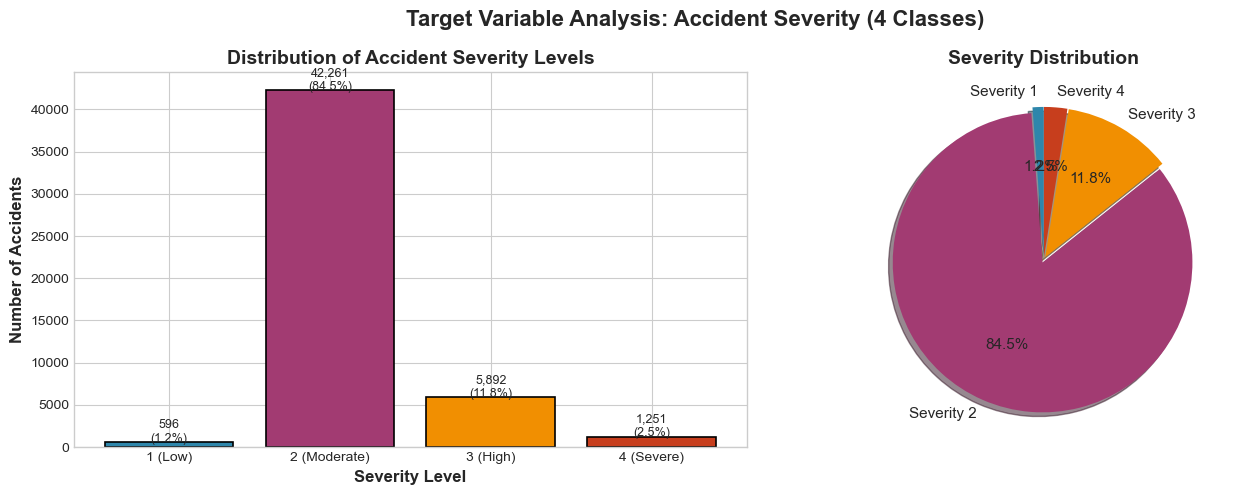

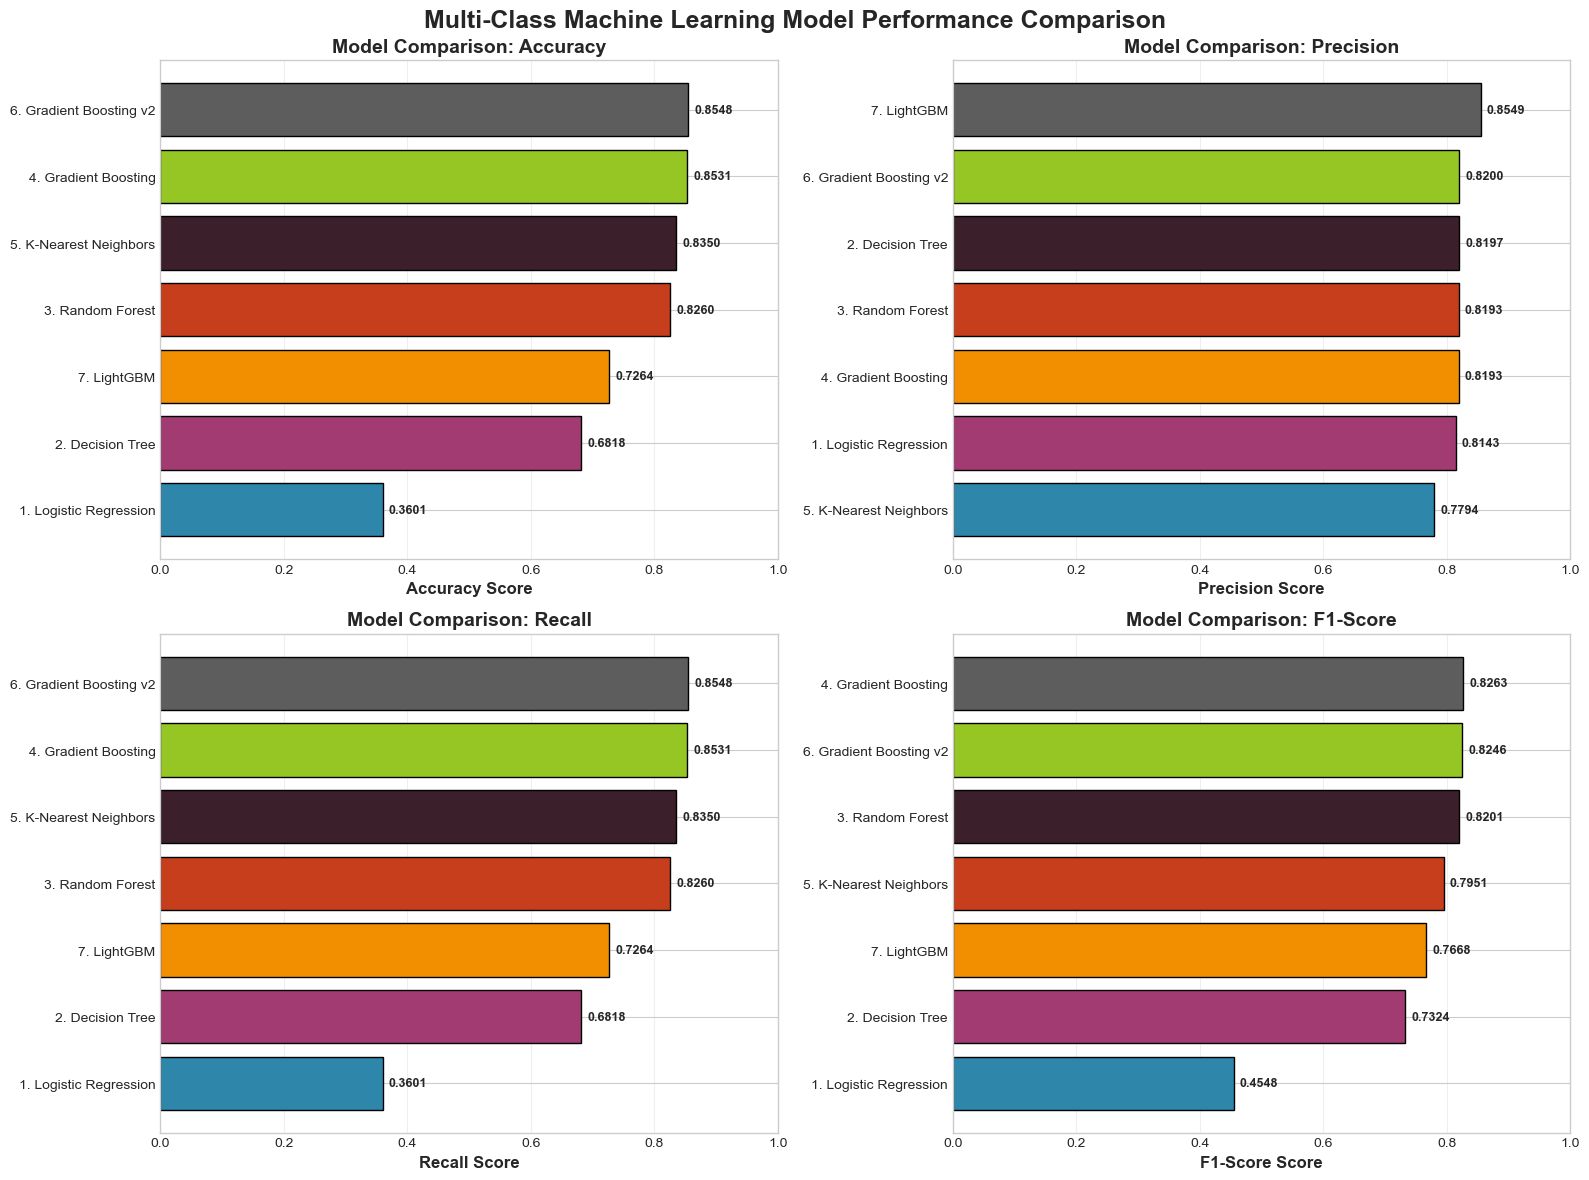

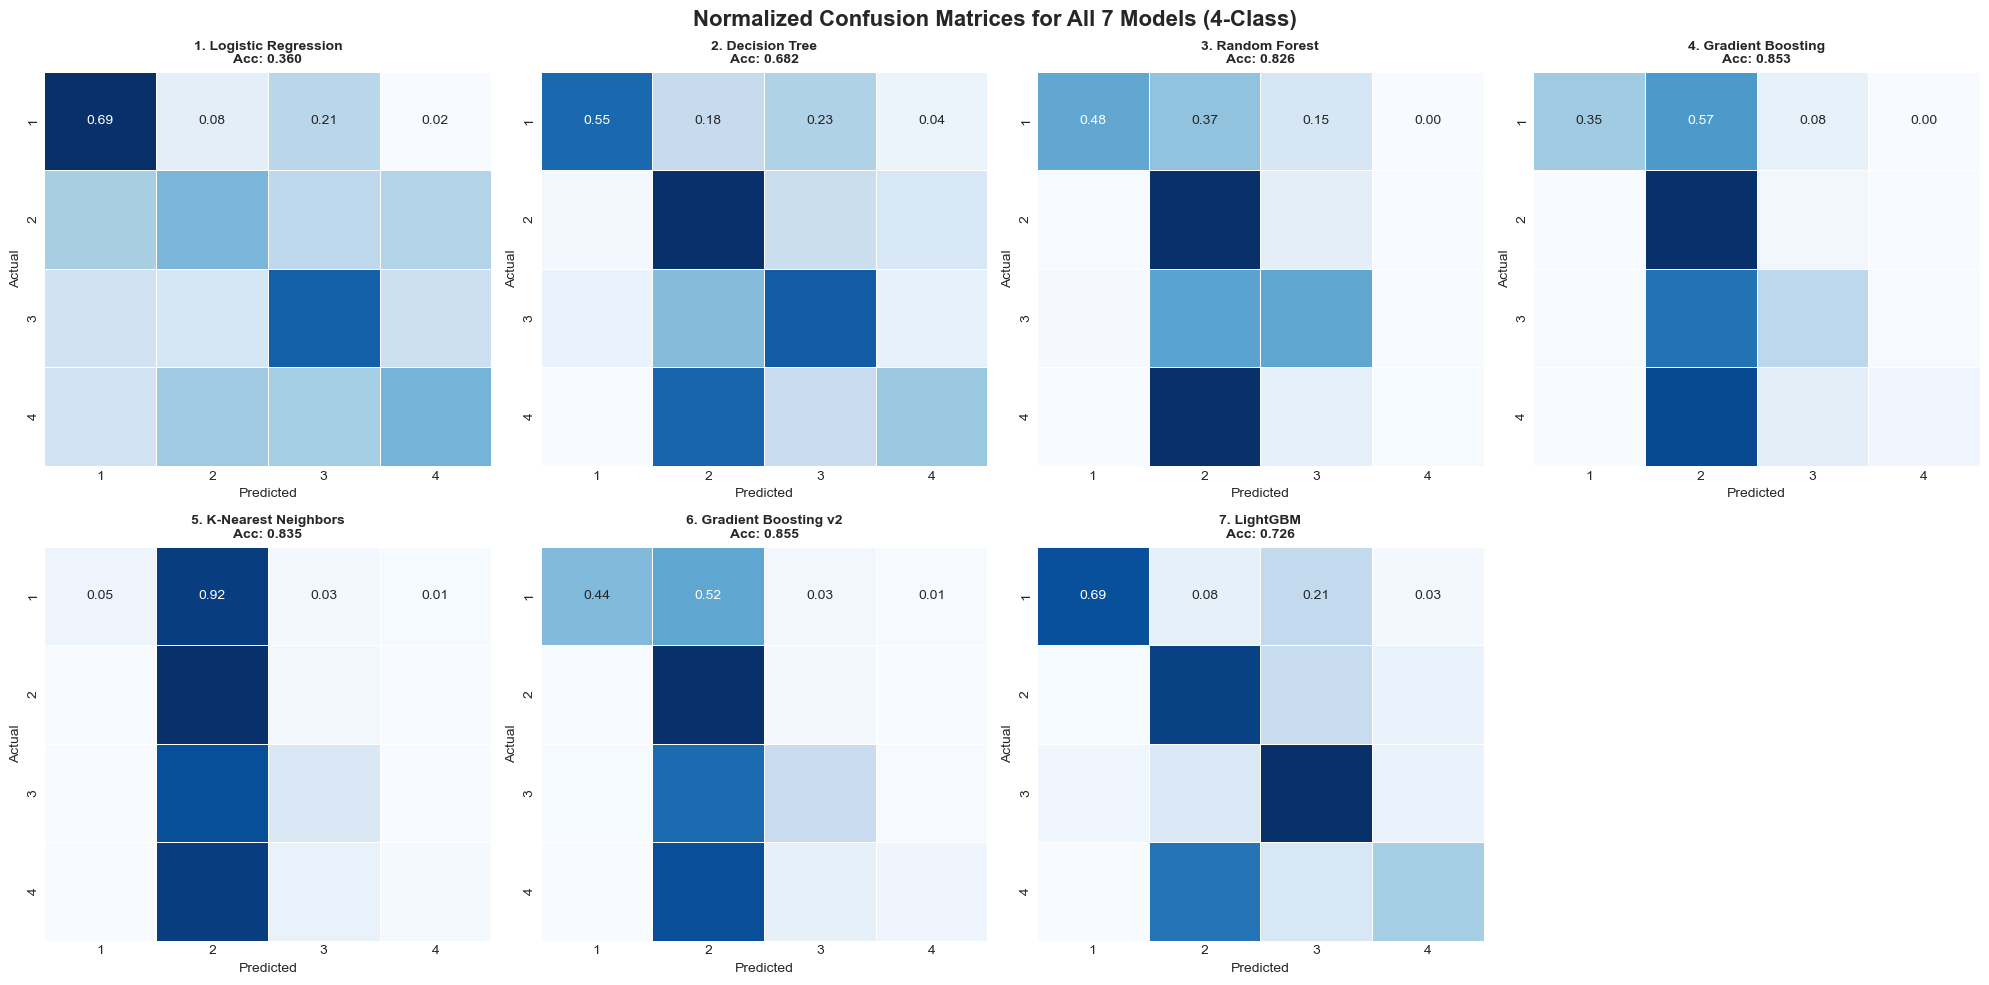

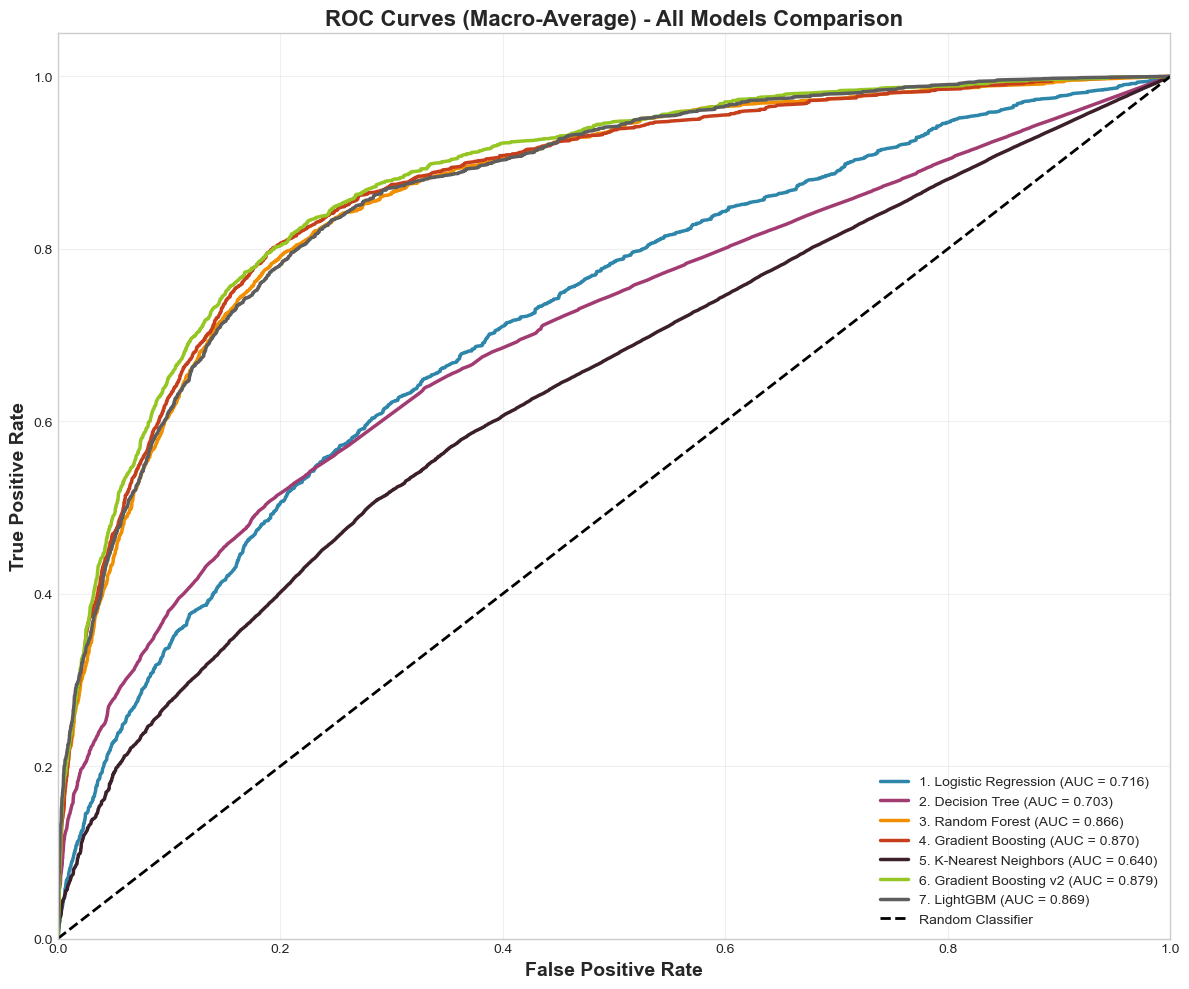

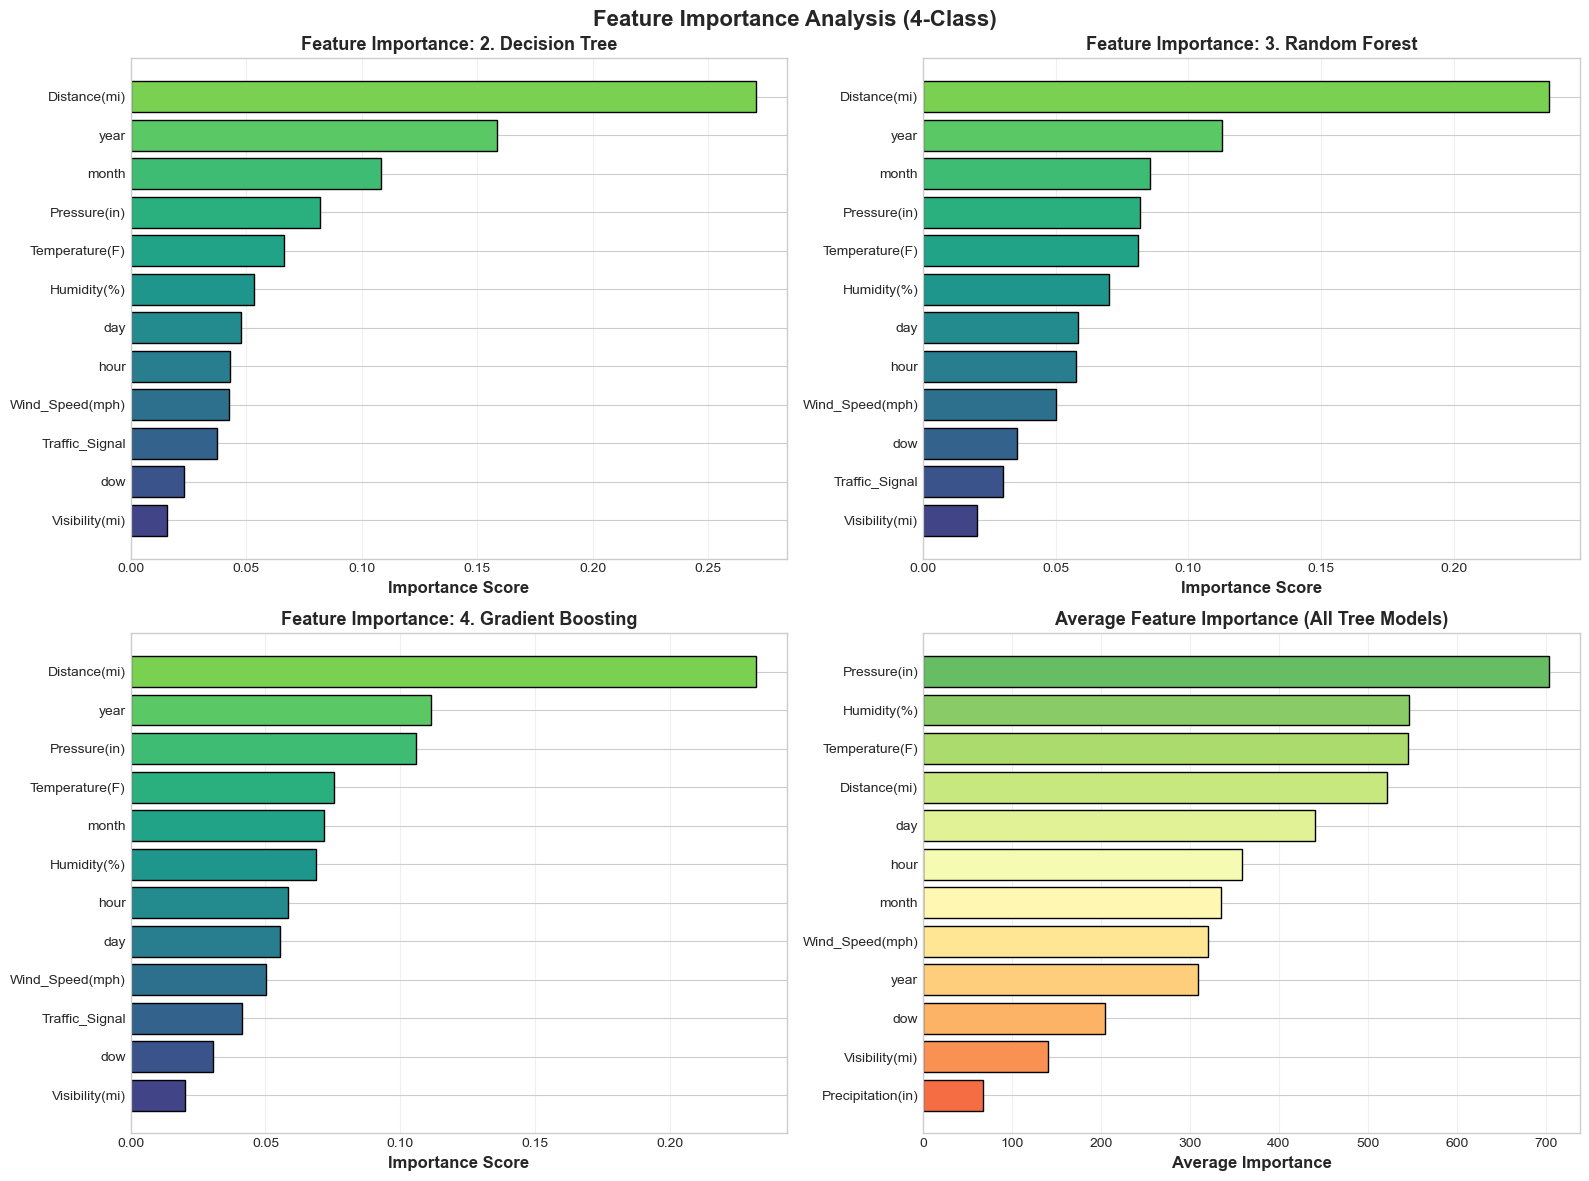

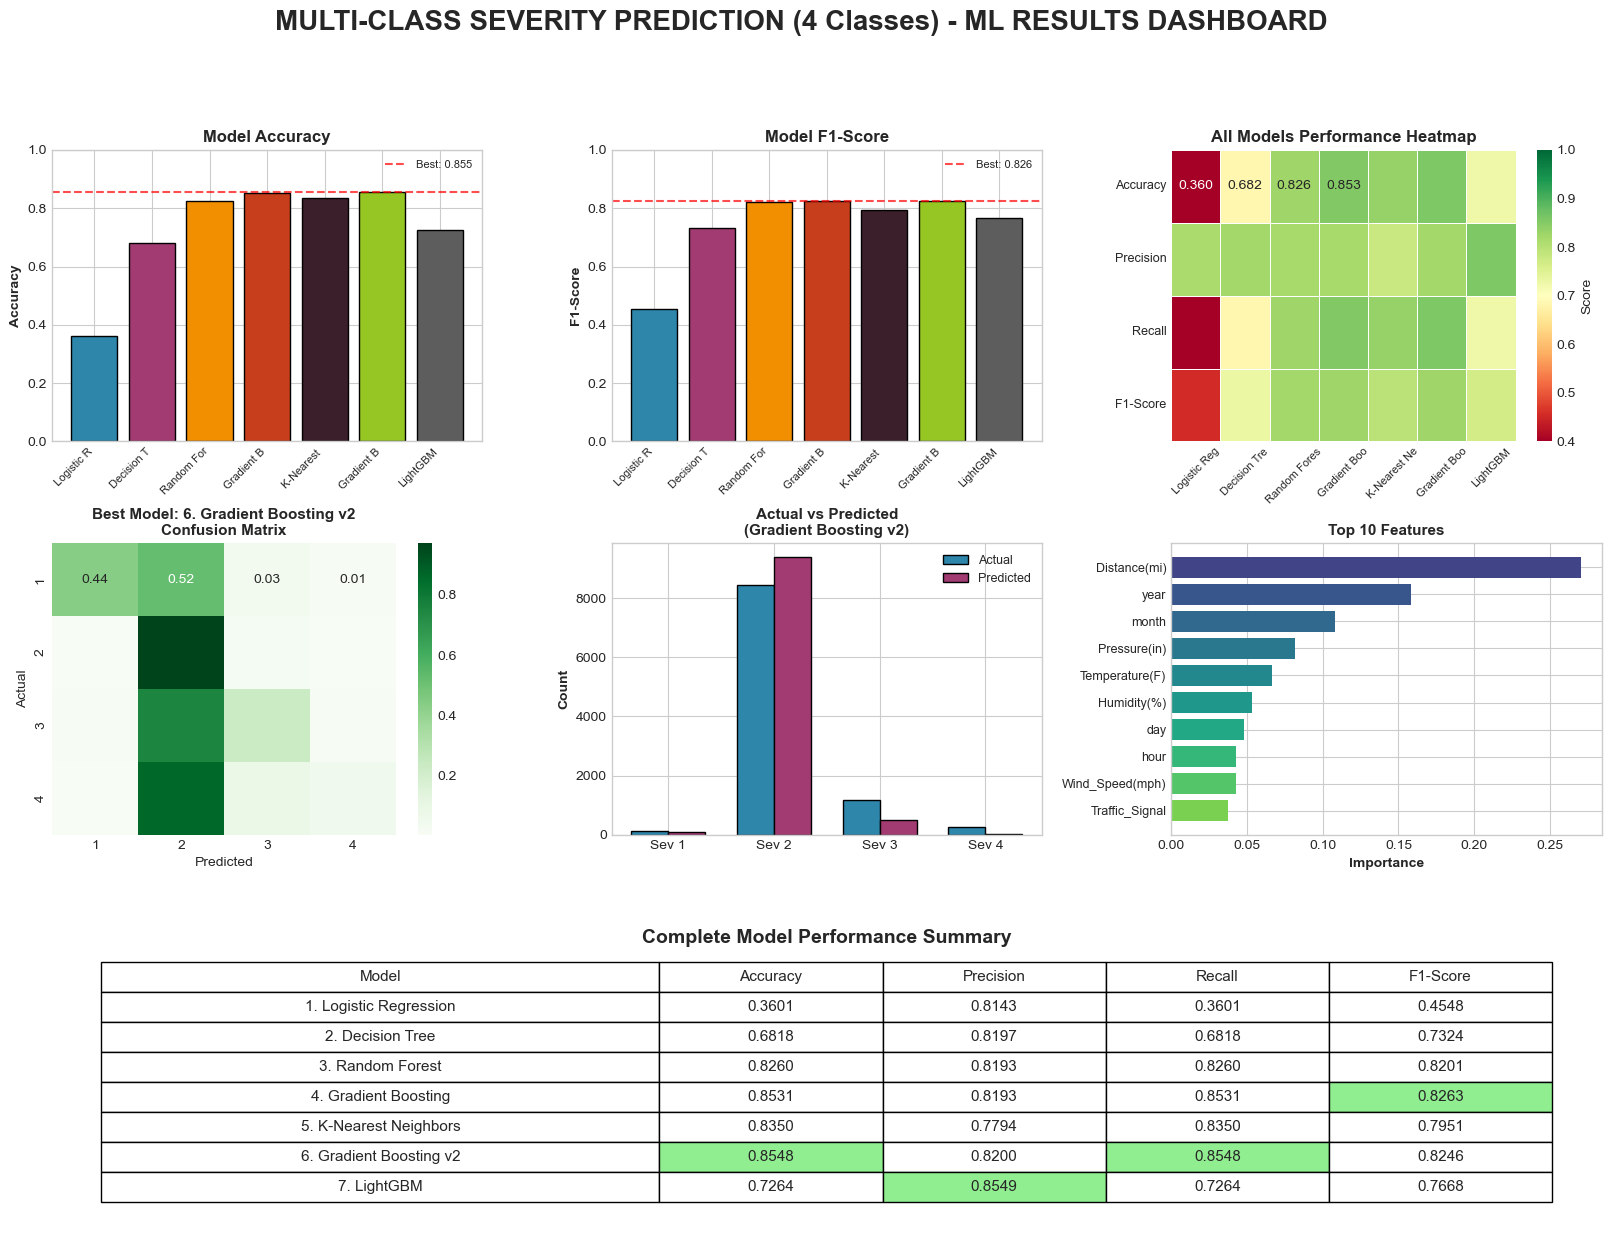


MULTI-CLASS MACHINE LEARNING ANALYSIS COMPLETE!

MODEL RANKINGS (by Accuracy):
--------------------------------------------------
🥇 1. 6. Gradient Boosting v2
      Accuracy: 0.8548 | F1: 0.8246
      Precision: 0.8200 | Recall: 0.8548
🥈 2. 4. Gradient Boosting
      Accuracy: 0.8531 | F1: 0.8263
      Precision: 0.8193 | Recall: 0.8531
🥉 3. 5. K-Nearest Neighbors
      Accuracy: 0.8350 | F1: 0.7951
      Precision: 0.7794 | Recall: 0.8350
   4. 3. Random Forest
      Accuracy: 0.8260 | F1: 0.8201
      Precision: 0.8193 | Recall: 0.8260
   5. 7. LightGBM
      Accuracy: 0.7264 | F1: 0.7668
      Precision: 0.8549 | Recall: 0.7264
   6. 2. Decision Tree
      Accuracy: 0.6818 | F1: 0.7324
      Precision: 0.8197 | Recall: 0.6818
   7. 1. Logistic Regression
      Accuracy: 0.3601 | F1: 0.4548
      Precision: 0.8143 | Recall: 0.3601

!!!! BEST MODEL: 6. Gradient Boosting v2
   Accuracy: 0.8548
   F1-Score: 0.8246

DATA SAVED FOR TABLEAU EXPORT
Standard variable names created:
  • resu

In [16]:
# =============================================================================
# US ACCIDENTS SEVERITY PREDICTION - MULTI-CLASS CLASSIFICATION (4 CLASSES)
# =============================================================================
# UNIQUE VARIABLE NAMES: multiclass_* prefix to avoid conflicts with binary
# Target: Severity (1, 2, 3, 4)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize

# FASTER BOOSTING LIBRARIES
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception as e:  # catch XGBoostError and others
    XGBOOST_AVAILABLE = False
    print("XGBoost not available, skipping. Reason:")
    print(e)


try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not installed. Run: pip install lightgbm")

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#95C623', '#5D5D5D']

print("=" * 70)
print("MULTI-CLASS CLASSIFICATION: 4 SEVERITY LEVELS (1, 2, 3, 4)")
print("=" * 70)

# =============================================================================
# STEP 1: PREPARE DATA FOR MULTI-CLASS ML
# =============================================================================
print("\n[1] PREPARING DATA FOR MULTI-CLASS MACHINE LEARNING...")
print("-" * 50)

# Select features for ML
numeric_features = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                    'Wind_Speed(mph)', 'Precipitation(in)', 'Distance(mi)']

bool_features = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
                 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                 'Traffic_Signal']

time_features = ['hour', 'dow', 'month', 'year', 'day', 'is_weekend', 
                 'is_morning_peak', 'is_evening_peak']

weather_flags = ['is_rain', 'is_snow', 'is_fog', 'is_thunder', 'is_wind', 'is_night']

# Combine all available features
all_features = []
for f in numeric_features + bool_features + time_features + weather_flags:
    if f in df.columns:
        all_features.append(f)

print(f"Features selected: {len(all_features)}")

# Create ML dataset
ml_df = df[all_features + ['Severity']].copy()
ml_df = ml_df.dropna()
print(f"Samples after dropping NaN: {len(ml_df):,}")

# OPTIMIZED SAMPLING
SAMPLE_SIZE = 50000

if len(ml_df) > SAMPLE_SIZE:
    ml_df = ml_df.sample(n=SAMPLE_SIZE, random_state=42)
    print(f"Sampled to: {len(ml_df):,} records for optimal training speed")

# Prepare X and y with UNIQUE names
multiclass_X = ml_df.drop('Severity', axis=1)
multiclass_y = ml_df['Severity']

# Encode labels
label_encoder = LabelEncoder()
multiclass_y_encoded = label_encoder.fit_transform(multiclass_y)
multiclass_original_classes = label_encoder.classes_
multiclass_n_classes = len(multiclass_original_classes)

print(f"\nTarget classes: {multiclass_original_classes}")
print(f"Class distribution:")
for cls, count in zip(*np.unique(multiclass_y_encoded, return_counts=True)):
    print(f"  Severity {multiclass_original_classes[cls]}: {count:,} ({count/len(multiclass_y_encoded)*100:.1f}%)")

# Train-test split with UNIQUE names
multiclass_X_train, multiclass_X_test, multiclass_y_train, multiclass_y_test = train_test_split(
    multiclass_X, multiclass_y_encoded, test_size=0.2, random_state=42, stratify=multiclass_y_encoded
)

# Scale features
multiclass_scaler = StandardScaler()
multiclass_X_train_scaled = multiclass_scaler.fit_transform(multiclass_X_train)
multiclass_X_test_scaled = multiclass_scaler.transform(multiclass_X_test)

print(f"\nTraining set: {multiclass_X_train.shape[0]:,} samples")
print(f"Test set: {multiclass_X_test.shape[0]:,} samples")
print(f"Features: {multiclass_X_train.shape[1]}")

# =============================================================================
# STEP 2: DEFINE 7 OPTIMIZED ML MODELS WITH UNIQUE NAMES
# =============================================================================
print("\n[2] TRAINING 7 ML MODELS FOR MULTI-CLASS CLASSIFICATION...")
print("-" * 50)

multiclass_models = {
    '1. Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced', 
        multi_class='multinomial', n_jobs=-1
    ),
    '2. Decision Tree': DecisionTreeClassifier(
        max_depth=20, min_samples_split=10, random_state=42, class_weight='balanced'
    ),
    '3. Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=20, min_samples_split=5,
        random_state=42, class_weight='balanced', n_jobs=-1
    ),
    '4. Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150, max_depth=8, learning_rate=0.1, random_state=42
    ),
    '5. K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5, weights='distance', n_jobs=-1
    ),
}

# Add XGBoost if available
if XGBOOST_AVAILABLE:
    multiclass_models['6. XGBoost'] = XGBClassifier(
        n_estimators=200, max_depth=10, learning_rate=0.1,
        random_state=42, n_jobs=-1, eval_metric='mlogloss'
    )
else:
    multiclass_models['6. Gradient Boosting v2'] = GradientBoostingClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.15, random_state=42
    )

# Add LightGBM if available
if LIGHTGBM_AVAILABLE:
    multiclass_models['7. LightGBM'] = LGBMClassifier(
        n_estimators=200, max_depth=15, learning_rate=0.1,
        random_state=42, n_jobs=-1, verbose=-1, class_weight='balanced'
    )
else:
    multiclass_models['7. Neural Network'] = MLPClassifier(
        hidden_layer_sizes=(100, 50), max_iter=300, random_state=42, early_stopping=True
    )

# Store results with UNIQUE names
multiclass_results = {}
multiclass_predictions = {}
multiclass_probabilities = {}
multiclass_feature_names = multiclass_X.columns.tolist()

# Train each model
for name, model in multiclass_models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for distance-based models
    if any(x in name for x in ['Logistic', 'KNN', 'Neighbors', 'Neural']):
        model.fit(multiclass_X_train_scaled, multiclass_y_train)
        y_pred = model.predict(multiclass_X_test_scaled)
        y_prob = model.predict_proba(multiclass_X_test_scaled)
    else:
        model.fit(multiclass_X_train, multiclass_y_train)
        y_pred = model.predict(multiclass_X_test)
        y_prob = model.predict_proba(multiclass_X_test)
    
    multiclass_predictions[name] = y_pred
    multiclass_probabilities[name] = y_prob
    
    multiclass_results[name] = {
        'Accuracy': accuracy_score(multiclass_y_test, y_pred),
        'Precision': precision_score(multiclass_y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(multiclass_y_test, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(multiclass_y_test, y_pred, average='weighted', zero_division=0)
    }
    
    print(f"  ✓ Accuracy: {multiclass_results[name]['Accuracy']:.4f} | F1-Score: {multiclass_results[name]['F1-Score']:.4f}")

print("\n" + "=" * 50)
print("✓ ALL 7 MODELS TRAINED SUCCESSFULLY!")
print("=" * 50)

# =============================================================================
# CREATE ALIASES FOR TABLEAU EXPORT (Standard names)
# =============================================================================
print("\n[4] Creating aliases for Tableau export...")
print("-" * 50)

# These are the standard names that the Tableau export script expects
results = multiclass_results
predictions = multiclass_predictions
probabilities = multiclass_probabilities
models = multiclass_models
feature_names = multiclass_feature_names
y_test = multiclass_y_test
X_test = multiclass_X_test

print("✓ Standard variable names created for Tableau export compatibility")
print("  Variables available: results, predictions, probabilities, models, feature_names, y_test, X_test")

# =============================================================================
# VISUALIZATION 1: CLASS DISTRIBUTION
# =============================================================================
print("\n[5] GENERATING ML VISUALIZATIONS...")
print("-" * 50)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

severity_counts = pd.Series(multiclass_y_encoded).value_counts().sort_index()
colors_sev = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'][:multiclass_n_classes]

# Bar plot
bars = axes[0].bar(range(len(severity_counts)), severity_counts.values, color=colors_sev, 
                   edgecolor='black', linewidth=1.2)
axes[0].set_xlabel('Severity Level', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Accidents', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Accident Severity Levels', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(multiclass_original_classes)))
severity_names = ['Low', 'Moderate', 'High', 'Severe'][:multiclass_n_classes]
axes[0].set_xticklabels([f'{c} ({severity_names[i]})' for i, c in enumerate(multiclass_original_classes)])

for bar, count in zip(bars, severity_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                f'{count:,}\n({count/len(multiclass_y_encoded)*100:.1f}%)', ha='center', fontsize=9)

# Pie chart
axes[1].pie(severity_counts.values, 
            labels=[f'Severity {c}' for c in multiclass_original_classes],
            colors=colors_sev, autopct='%1.1f%%', startangle=90, 
            explode=[0.02]*len(severity_counts), shadow=True, textprops={'fontsize': 11})
axes[1].set_title('Severity Distribution', fontsize=14, fontweight='bold')

plt.suptitle('Target Variable Analysis: Accident Severity (4 Classes)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 2: MODEL PERFORMANCE COMPARISON
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

multiclass_results_df = pd.DataFrame(multiclass_results).T
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    sorted_results = multiclass_results_df[metric].sort_values(ascending=True)
    
    bars = ax.barh(range(len(sorted_results)), sorted_results.values, 
                   color=COLORS[:len(sorted_results)], edgecolor='black', linewidth=1)
    
    ax.set_yticks(range(len(sorted_results)))
    ax.set_yticklabels(sorted_results.index, fontsize=10)
    ax.set_xlabel(f'{metric} Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Model Comparison: {metric}', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(True, axis='x', alpha=0.3)
    
    for bar, val in zip(bars, sorted_results.values):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
               f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

plt.suptitle('Multi-Class Machine Learning Model Performance Comparison', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 3: CONFUSION MATRICES
# =============================================================================
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

class_labels = [str(c) for c in multiclass_original_classes]

for idx, (name, y_pred) in enumerate(multiclass_predictions.items()):
    ax = axes[idx]
    
    cm = confusion_matrix(multiclass_y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                xticklabels=class_labels, yticklabels=class_labels,
                cbar=False, linewidths=0.5, linecolor='white')
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Actual', fontsize=10)
    ax.set_title(f'{name}\nAcc: {multiclass_results[name]["Accuracy"]:.3f}', fontsize=10, fontweight='bold')

axes[7].axis('off')
plt.suptitle('Normalized Confusion Matrices for All 7 Models (4-Class)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 4: ROC CURVES
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 10))

classes = list(range(multiclass_n_classes))
multiclass_y_test_bin = label_binarize(multiclass_y_test, classes=classes)

for idx, (name, y_prob) in enumerate(multiclass_probabilities.items()):
    fpr = dict()
    tpr = dict()
    
    for i in range(multiclass_n_classes):
        fpr[i], tpr[i], _ = roc_curve(multiclass_y_test_bin[:, i], y_prob[:, i])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(multiclass_n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(multiclass_n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= multiclass_n_classes
    
    macro_auc = auc(all_fpr, mean_tpr)
    ax.plot(all_fpr, mean_tpr, color=COLORS[idx], lw=2.5, 
           label=f'{name} (AUC = {macro_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curves (Macro-Average) - All Models Comparison', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 5: FEATURE IMPORTANCE
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get tree-based models for feature importance
multiclass_importance_models = {}
for name, model in multiclass_models.items():
    if hasattr(model, 'feature_importances_'):
        multiclass_importance_models[name] = model

# Plot top 3 + average
plot_models = list(multiclass_importance_models.items())[:3]

for idx, (name, model) in enumerate(plot_models):
    ax = axes[idx // 2, idx % 2]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:12]
    
    colors_imp = plt.cm.viridis(np.linspace(0.2, 0.8, len(indices)))[::-1]
    
    ax.barh(range(len(indices)), importances[indices], color=colors_imp, edgecolor='black')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([multiclass_feature_names[i] for i in indices], fontsize=10)
    ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Feature Importance: {name}', fontsize=13, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, axis='x', alpha=0.3)

# Average importance
ax = axes[1, 1]
avg_importance = np.zeros(len(multiclass_feature_names))
for name, model in multiclass_importance_models.items():
    avg_importance += model.feature_importances_
avg_importance /= len(multiclass_importance_models)

indices = np.argsort(avg_importance)[::-1][:12]
colors_imp = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(indices)))[::-1]

ax.barh(range(len(indices)), avg_importance[indices], color=colors_imp, edgecolor='black')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([multiclass_feature_names[i] for i in indices], fontsize=10)
ax.set_xlabel('Average Importance', fontsize=12, fontweight='bold')
ax.set_title('Average Feature Importance (All Tree Models)', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, axis='x', alpha=0.3)

plt.suptitle('Feature Importance Analysis (4-Class)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 6: COMPREHENSIVE SUMMARY DASHBOARD
# =============================================================================
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Accuracy Comparison
ax1 = fig.add_subplot(gs[0, 0])
accuracies = [multiclass_results[m]['Accuracy'] for m in multiclass_models.keys()]
model_short = [m.split('. ')[1][:10] for m in multiclass_models.keys()]
bars = ax1.bar(range(len(multiclass_models)), accuracies, color=COLORS, edgecolor='black')
ax1.set_xticks(range(len(multiclass_models)))
ax1.set_xticklabels(model_short, rotation=45, ha='right', fontsize=8)
ax1.set_ylabel('Accuracy', fontsize=10, fontweight='bold')
ax1.set_title('Model Accuracy', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.axhline(y=max(accuracies), color='red', linestyle='--', alpha=0.7, label=f'Best: {max(accuracies):.3f}')
ax1.legend(fontsize=8)

# 2. F1-Score Comparison
ax2 = fig.add_subplot(gs[0, 1])
f1_scores = [multiclass_results[m]['F1-Score'] for m in multiclass_models.keys()]
bars = ax2.bar(range(len(multiclass_models)), f1_scores, color=COLORS, edgecolor='black')
ax2.set_xticks(range(len(multiclass_models)))
ax2.set_xticklabels(model_short, rotation=45, ha='right', fontsize=8)
ax2.set_ylabel('F1-Score', fontsize=10, fontweight='bold')
ax2.set_title('Model F1-Score', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.axhline(y=max(f1_scores), color='red', linestyle='--', alpha=0.7, label=f'Best: {max(f1_scores):.3f}')
ax2.legend(fontsize=8)

# 3. All Models Heatmap
ax3 = fig.add_subplot(gs[0, 2])
heatmap_data = multiclass_results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
model_labels = [m.split('. ')[1][:12] for m in heatmap_data.index]
sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax3,
            xticklabels=model_labels, yticklabels=heatmap_data.columns,
            cbar_kws={'label': 'Score'}, vmin=0.4, vmax=1.0, linewidths=0.5)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('All Models Performance Heatmap', fontsize=12, fontweight='bold')
ax3.tick_params(axis='x', rotation=45, labelsize=8)
ax3.tick_params(axis='y', rotation=0, labelsize=9)

# 4. Best Model Confusion Matrix
ax4 = fig.add_subplot(gs[1, 0])
best_model = max(multiclass_results.keys(), key=lambda x: multiclass_results[x]['Accuracy'])
cm = confusion_matrix(multiclass_y_test, multiclass_predictions[best_model])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=ax4,
            xticklabels=class_labels, yticklabels=class_labels)
ax4.set_xlabel('Predicted', fontsize=10)
ax4.set_ylabel('Actual', fontsize=10)
ax4.set_title(f'Best Model: {best_model}\nConfusion Matrix', fontsize=11, fontweight='bold')

# 5. Actual vs Predicted Distribution
ax5 = fig.add_subplot(gs[1, 1])
x_pos = np.arange(multiclass_n_classes)
width = 0.35
actual_counts = np.bincount(multiclass_y_test, minlength=multiclass_n_classes)
pred_counts = np.bincount(multiclass_predictions[best_model], minlength=multiclass_n_classes)
ax5.bar(x_pos - width/2, actual_counts, width, label='Actual', color=COLORS[0], edgecolor='black')
ax5.bar(x_pos + width/2, pred_counts, width, label='Predicted', color=COLORS[1], edgecolor='black')
ax5.set_xticks(x_pos)
ax5.set_xticklabels([f'Sev {c}' for c in multiclass_original_classes])
ax5.set_ylabel('Count', fontsize=10, fontweight='bold')
ax5.set_title(f'Actual vs Predicted\n({best_model.split(". ")[1]})', fontsize=11, fontweight='bold')
ax5.legend(fontsize=9)

# 6. Top Features
ax6 = fig.add_subplot(gs[1, 2])
if multiclass_importance_models:
    best_tree_model = list(multiclass_importance_models.values())[0]
    importances = best_tree_model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    ax6.barh(range(10), importances[indices], color=plt.cm.viridis(np.linspace(0.2, 0.8, 10)))
    ax6.set_yticks(range(10))
    ax6.set_yticklabels([multiclass_feature_names[i] for i in indices], fontsize=9)
    ax6.invert_yaxis()
    ax6.set_xlabel('Importance', fontsize=10, fontweight='bold')
    ax6.set_title('Top 10 Features', fontsize=11, fontweight='bold')

# 7. Results Table
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

table_data = []
for model in multiclass_models.keys():
    row = [model, 
           f"{multiclass_results[model]['Accuracy']:.4f}",
           f"{multiclass_results[model]['Precision']:.4f}",
           f"{multiclass_results[model]['Recall']:.4f}",
           f"{multiclass_results[model]['F1-Score']:.4f}"]
    table_data.append(row)

table = ax7.table(cellText=table_data,
                  colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                  cellLoc='center', loc='center',
                  colWidths=[0.3, 0.12, 0.12, 0.12, 0.12])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Highlight best values in green
for i, model in enumerate(multiclass_models.keys()):
    for j, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score']):
        max_val = max([multiclass_results[m][metric] for m in multiclass_models.keys()])
        if multiclass_results[model][metric] == max_val:
            table[(i+1, j+1)].set_facecolor('#90EE90')

ax7.set_title('Complete Model Performance Summary', fontsize=14, fontweight='bold', y=0.95)

plt.suptitle('MULTI-CLASS SEVERITY PREDICTION (4 Classes) - ML RESULTS DASHBOARD', 
             fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("MULTI-CLASS MACHINE LEARNING ANALYSIS COMPLETE!")
print("=" * 70)

print("\nMODEL RANKINGS (by Accuracy):")
print("-" * 50)
sorted_models = sorted(multiclass_results.items(), key=lambda x: x[1]['Accuracy'], reverse=True)
for rank, (model, metrics) in enumerate(sorted_models, 1):
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"{emoji} {rank}. {model}")
    print(f"      Accuracy: {metrics['Accuracy']:.4f} | F1: {metrics['F1-Score']:.4f}")
    print(f"      Precision: {metrics['Precision']:.4f} | Recall: {metrics['Recall']:.4f}")

print(f"\n!!!! BEST MODEL: {best_model}")
print(f"   Accuracy: {multiclass_results[best_model]['Accuracy']:.4f}")
print(f"   F1-Score: {multiclass_results[best_model]['F1-Score']:.4f}")

print("\n" + "=" * 70)
print("DATA SAVED FOR TABLEAU EXPORT")
print("=" * 70)
print("Standard variable names created:")
print("  • results, predictions, probabilities")
print("  • models, feature_names")
print("  • y_test, X_test")
print("\nNote: Run the Tableau export cell now to save CSV files!")
print("=" * 70)

BINARY CLASSIFICATION: LOW vs HIGH SEVERITY ACCIDENTS
  • LOW Severity  (0): Original Severity 1, 2 (minor impact)
  • HIGH Severity (1): Original Severity 3, 4 (major impact)

[1] PREPARING BINARY CLASSIFICATION DATA...
--------------------------------------------------
Features selected: 28

Original Severity Distribution:
Severity
1      62365
2    4567475
3     639364
4     131360
Name: count, dtype: int64

Binary Severity Distribution:
  LOW  (Severity 1,2): 4,629,840 (85.7%)
  HIGH (Severity 3,4): 770,724 (14.3%)

Sampled to: 50,000 records

Final Binary Distribution:
  LOW  (0): 25,000 (50.0%)
  HIGH (1): 25,000 (50.0%)

Training set: 40,000 samples
Test set: 10,000 samples
Features: 28

[2] TRAINING 8 ML MODELS FOR BINARY CLASSIFICATION...
--------------------------------------------------

Training 1. Logistic Regression...
  ✓ Accuracy: 0.6667 | F1: 0.6561 | AUC: 0.7276

Training 2. Decision Tree...
  ✓ Accuracy: 0.7529 | F1: 0.7613 | AUC: 0.7939

Training 3. Random Forest...

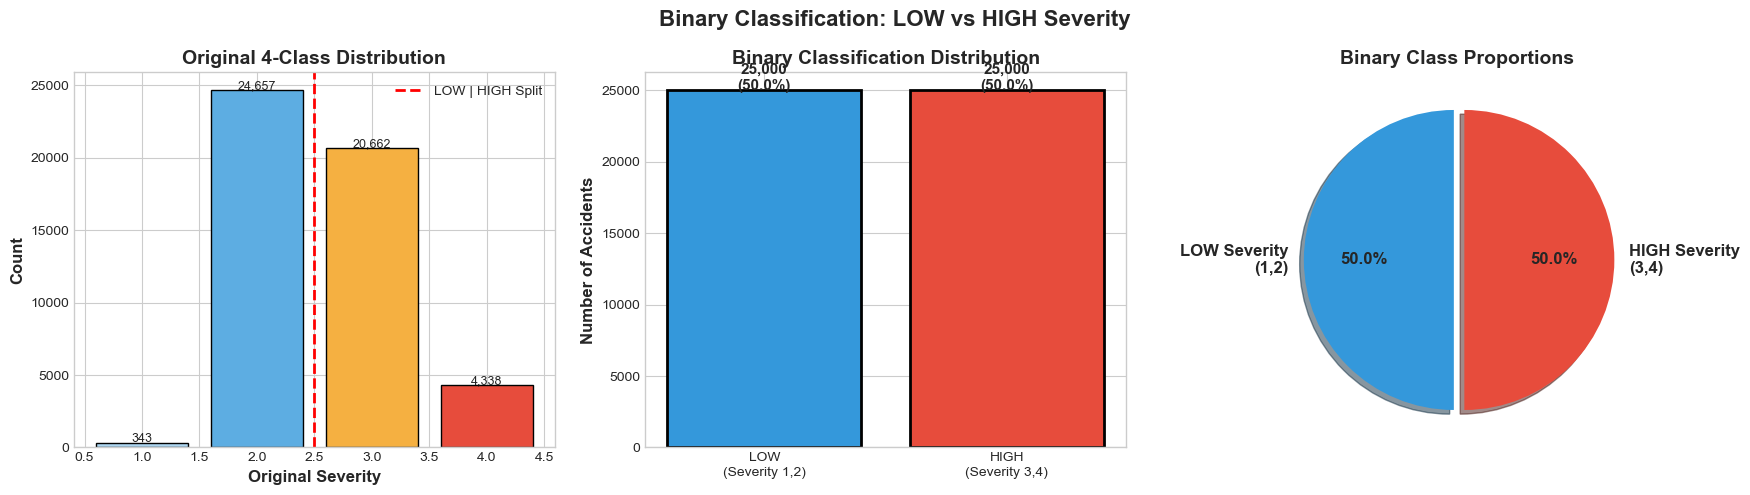

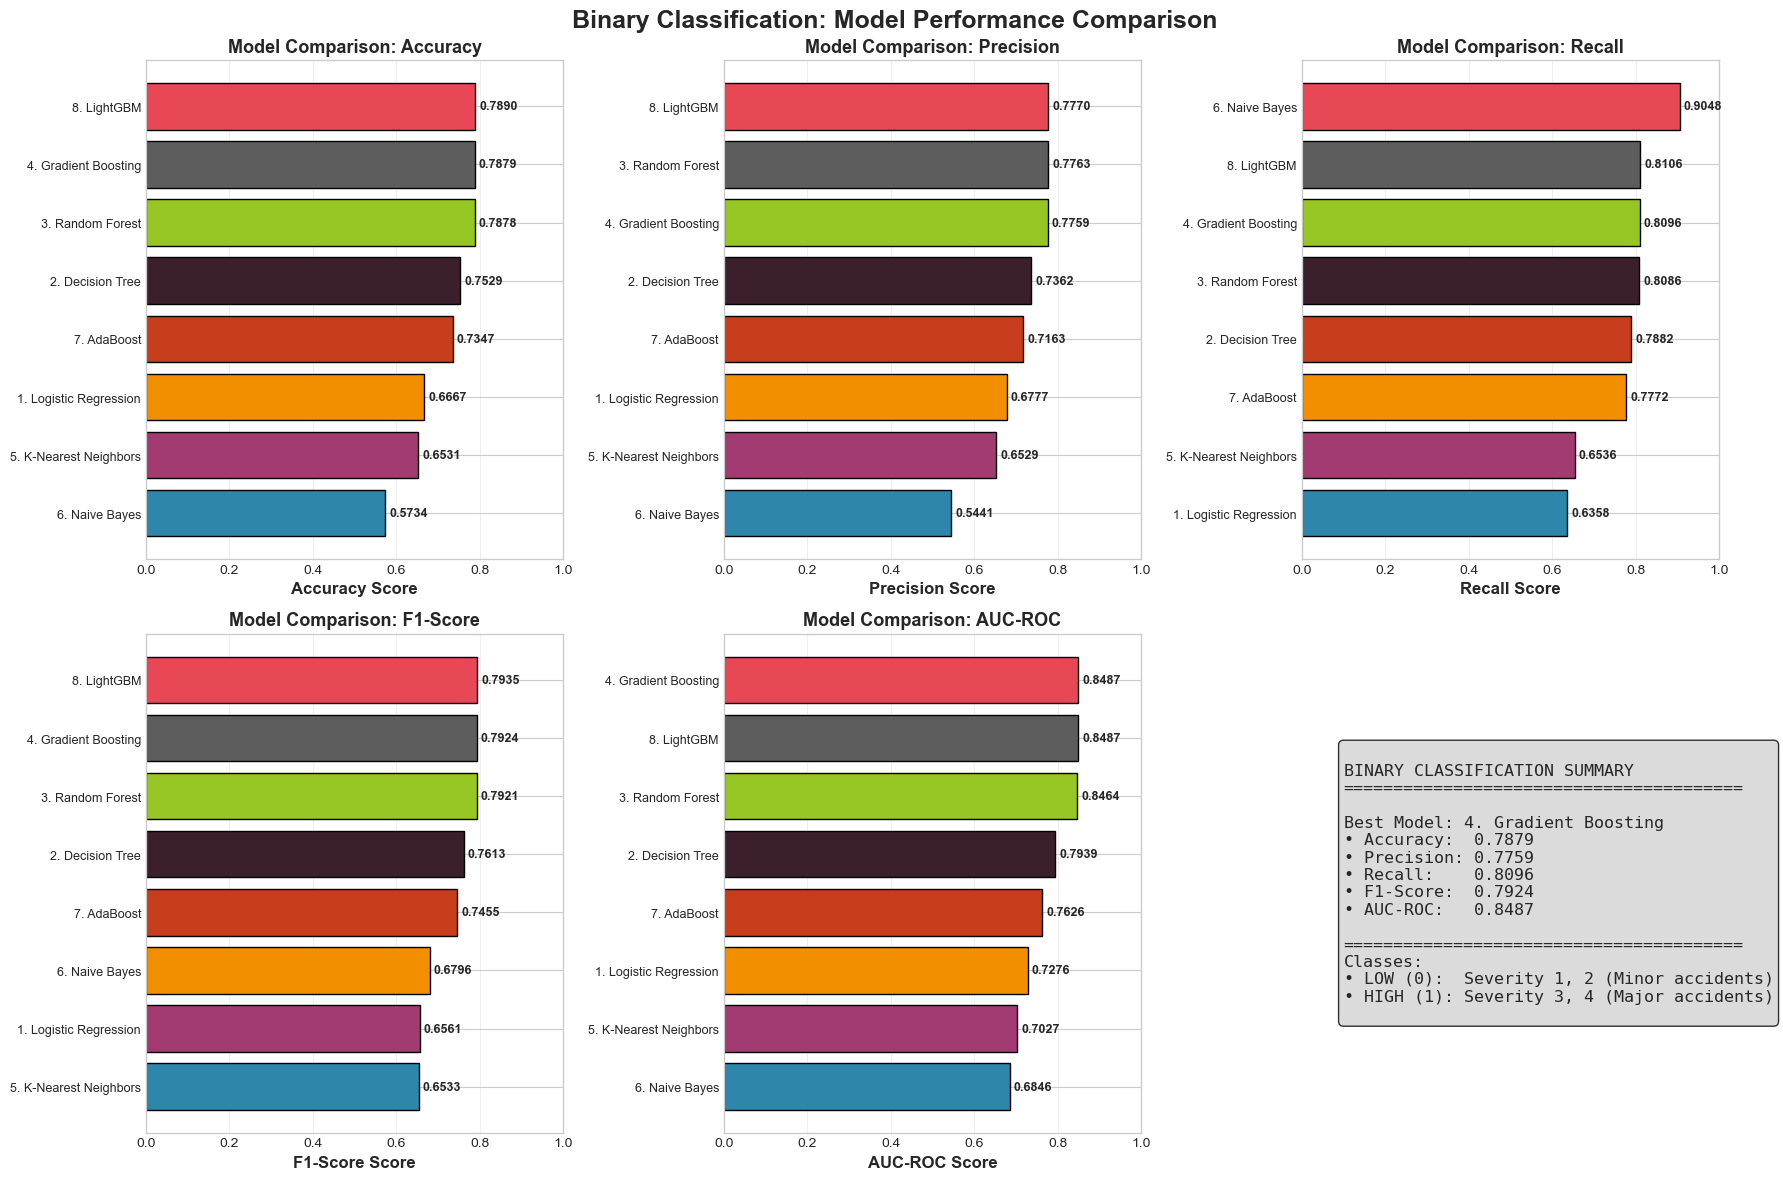

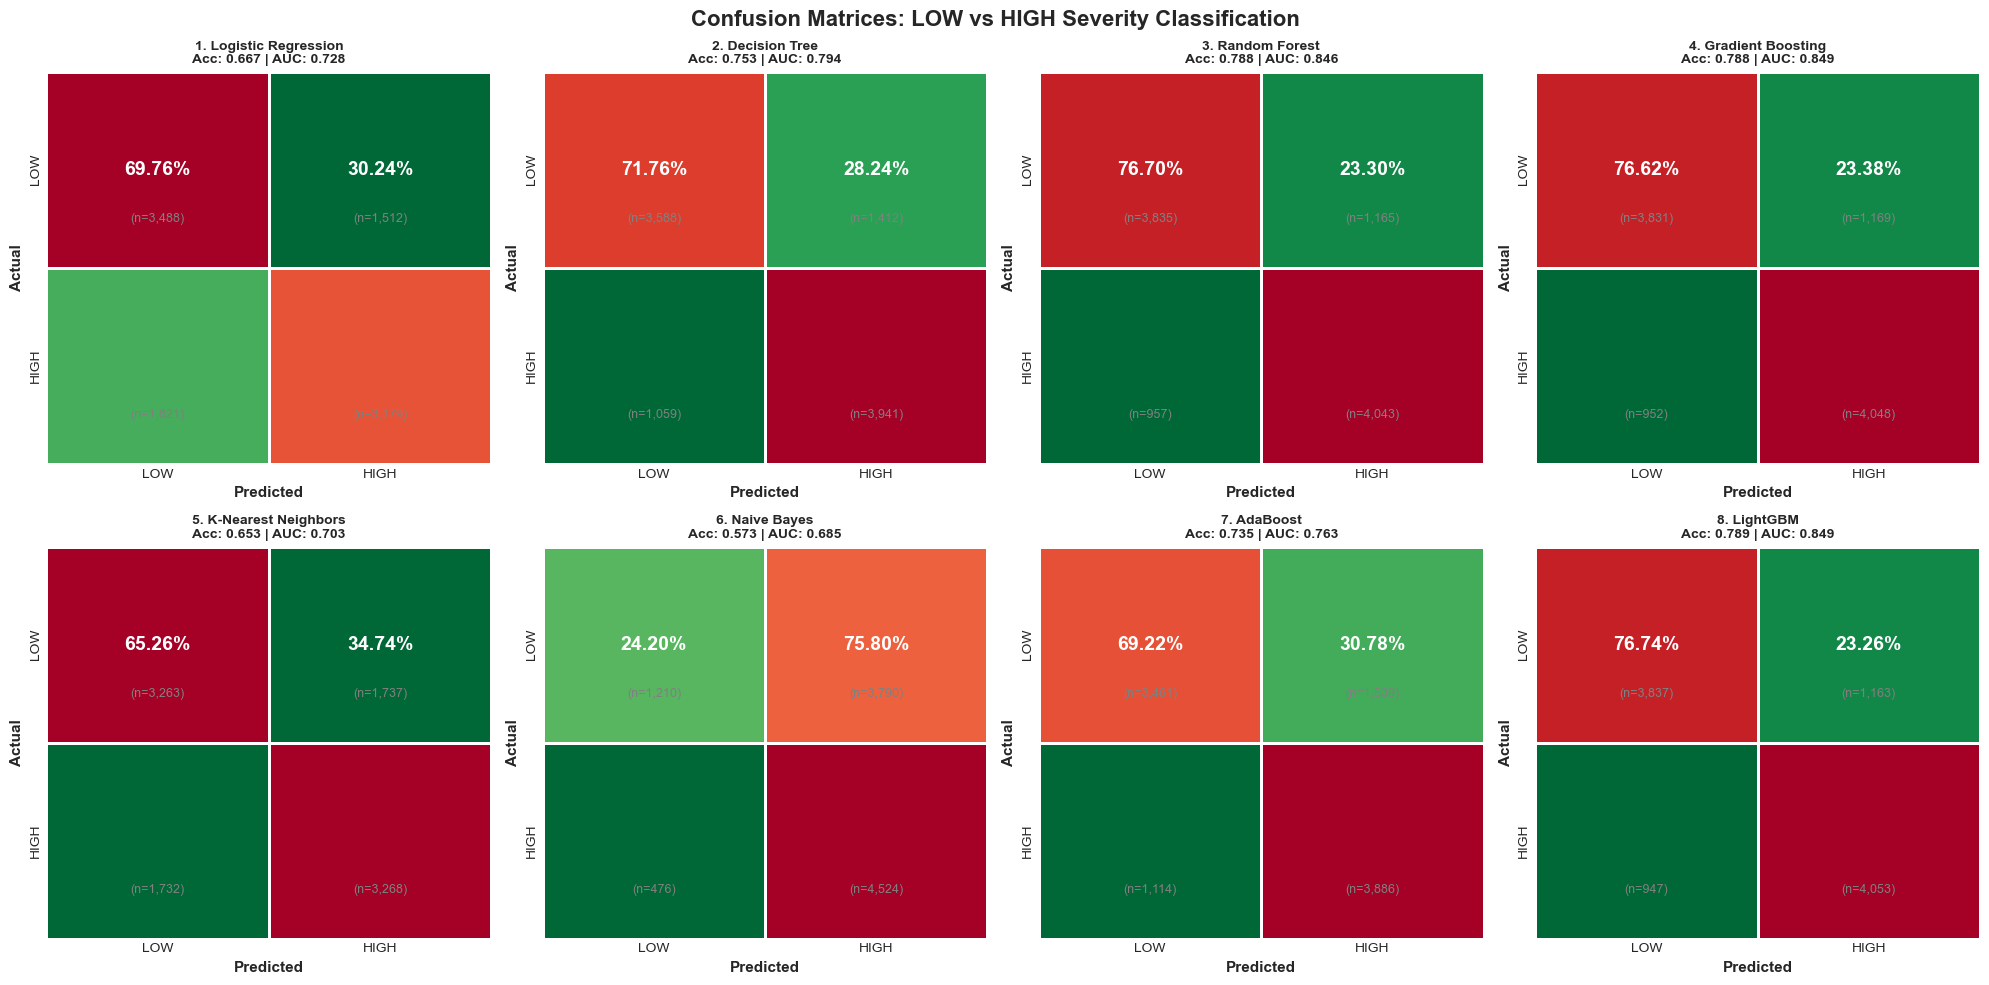

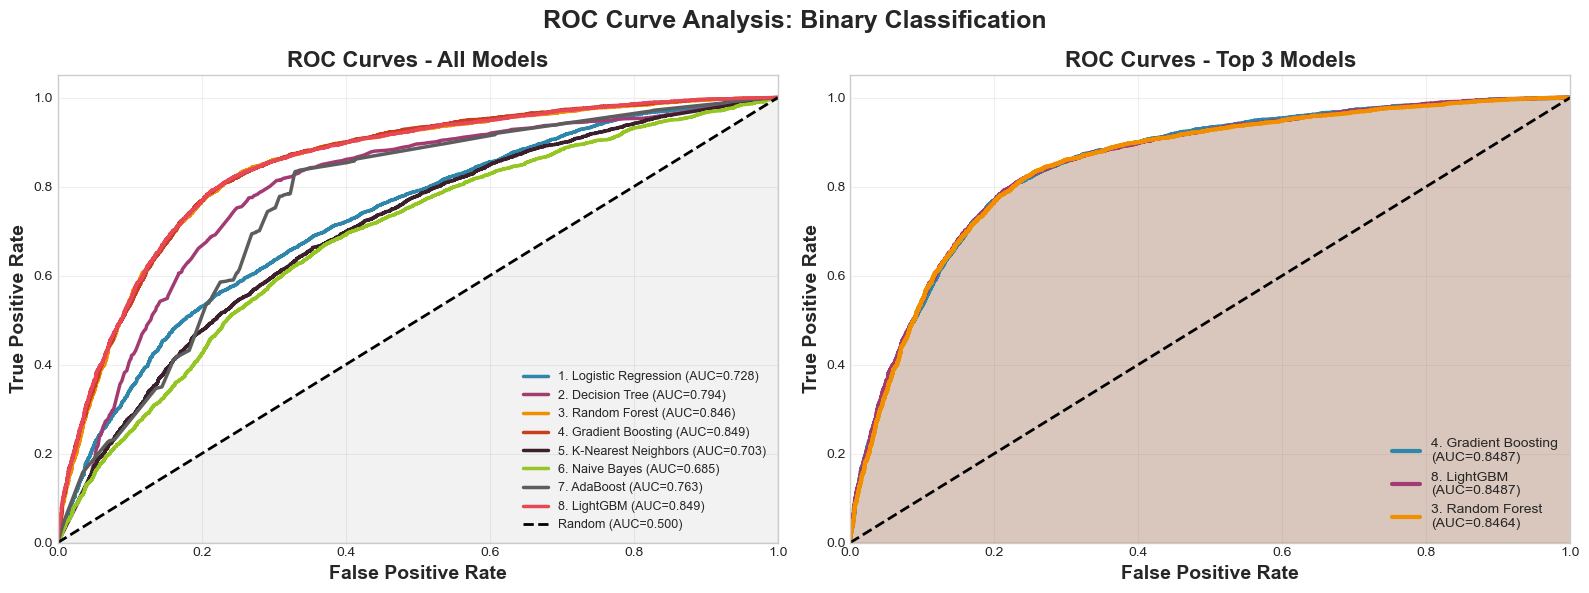

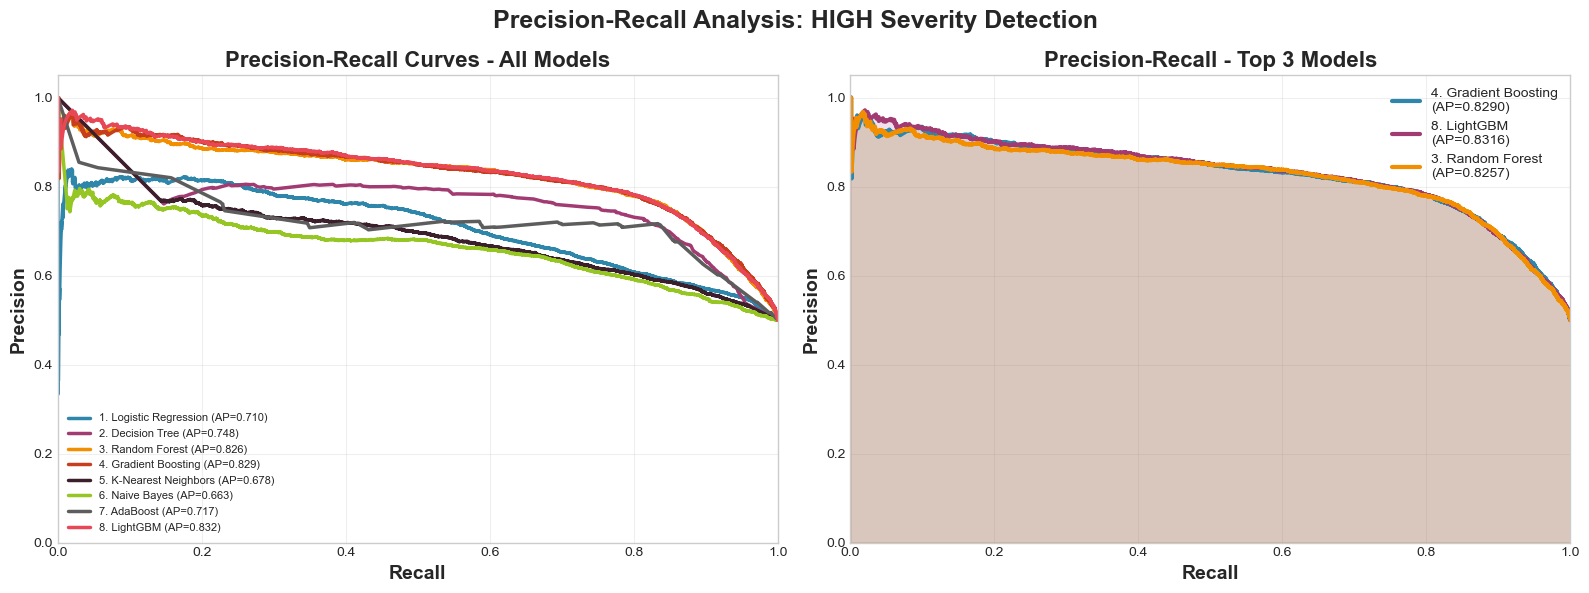

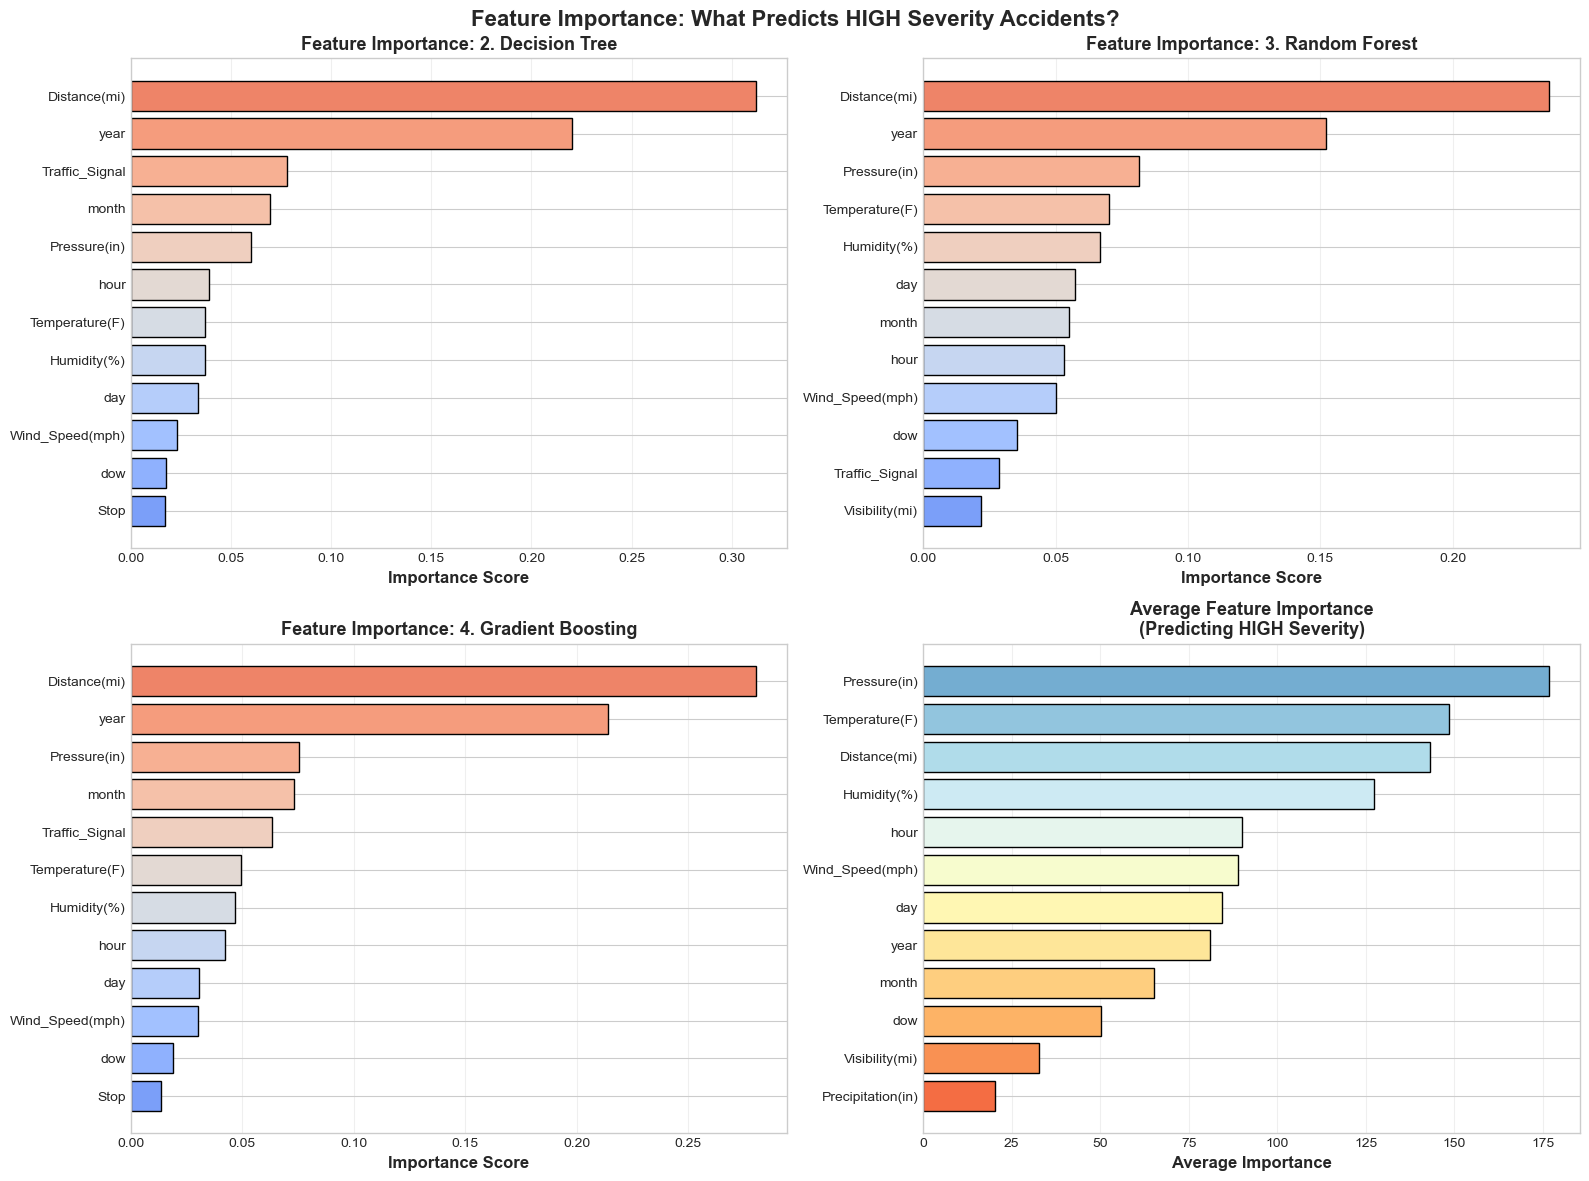

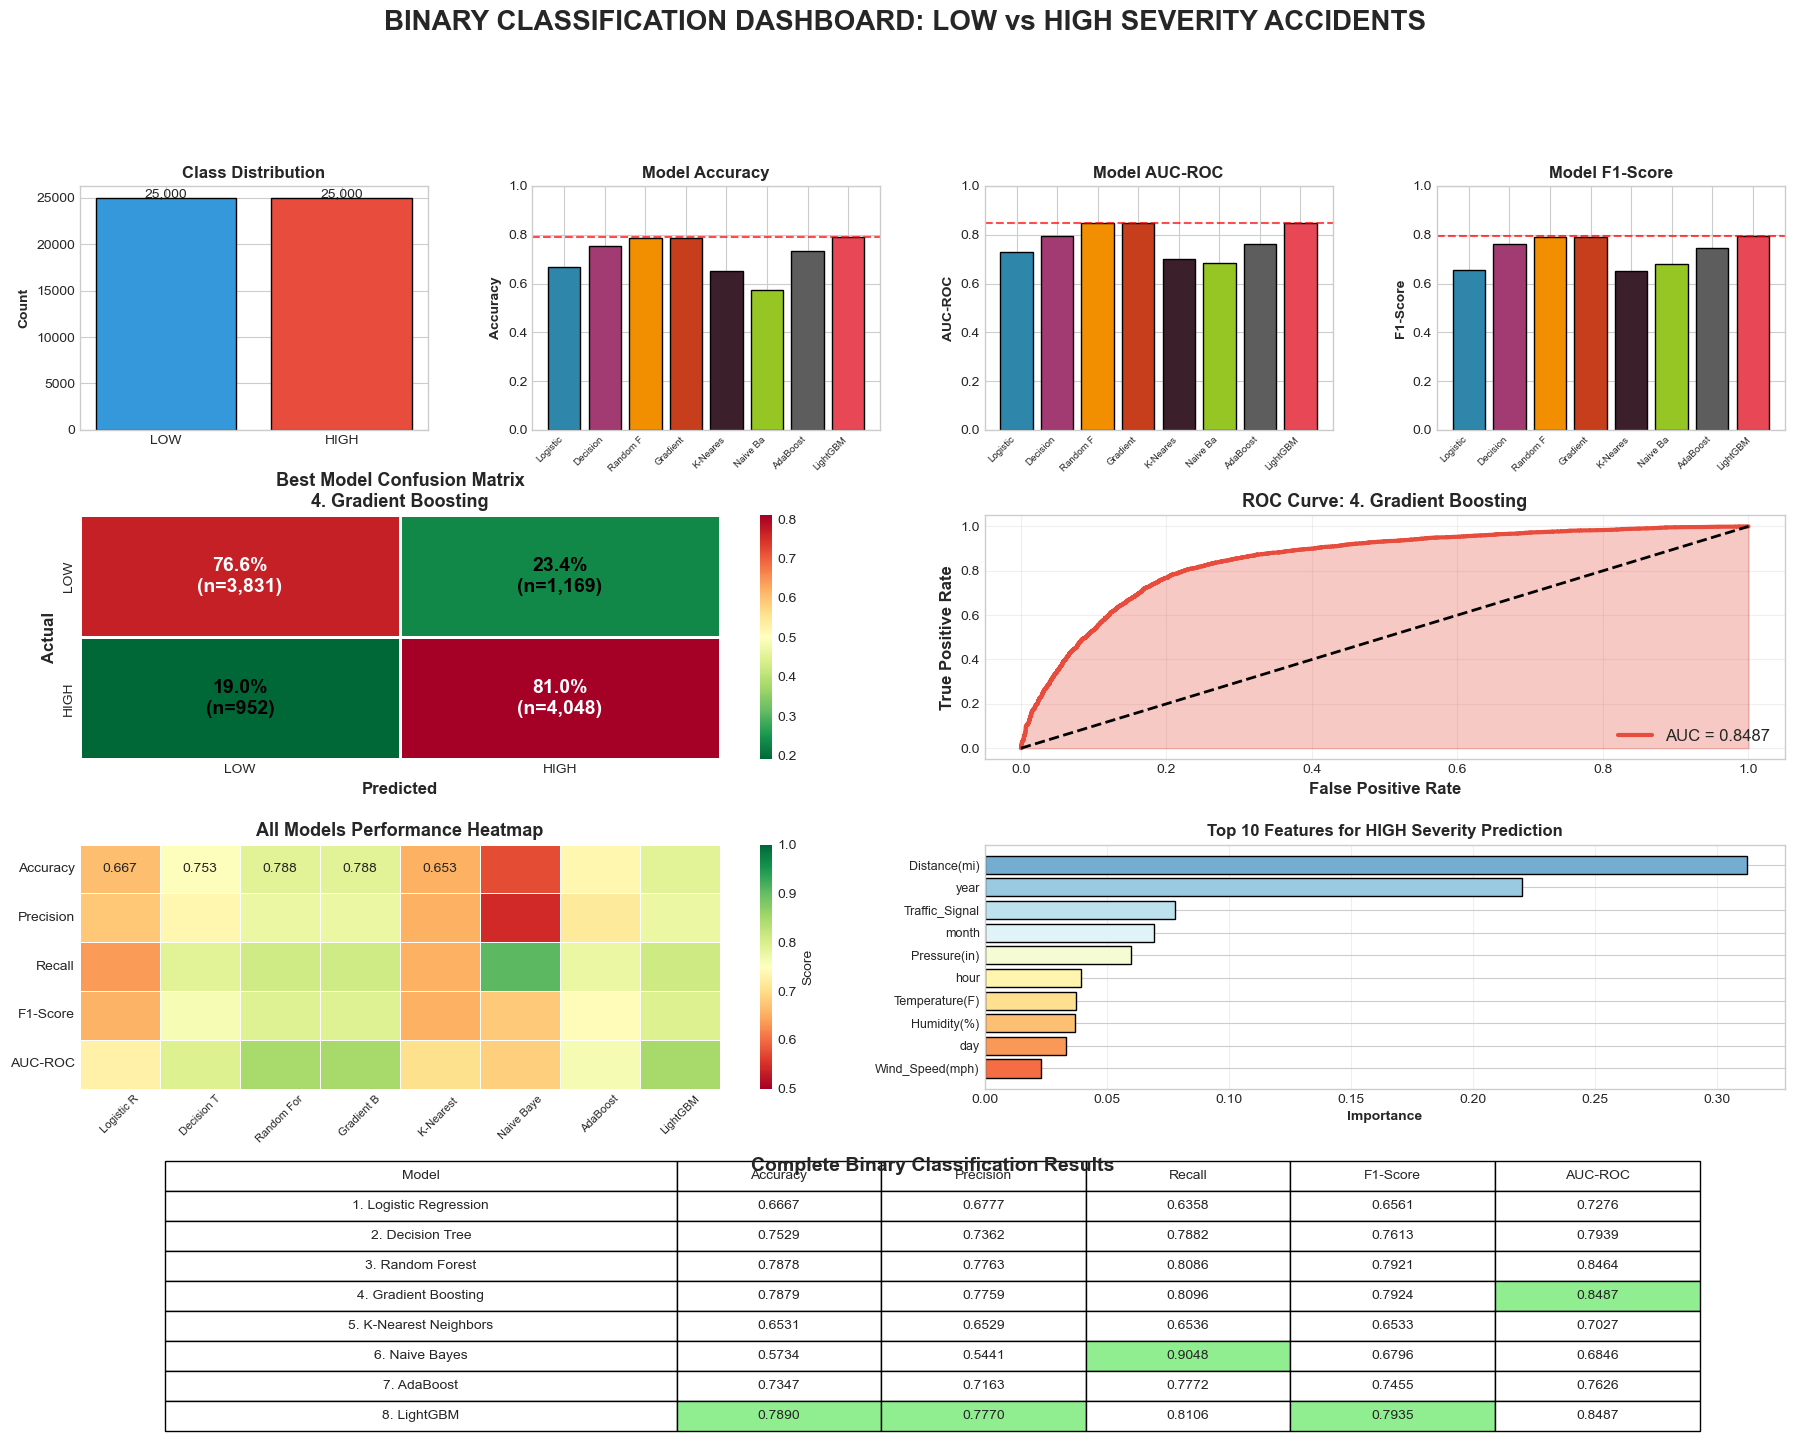


🎉 BINARY CLASSIFICATION ANALYSIS COMPLETE!

📊 MODEL RANKINGS (by AUC-ROC):
--------------------------------------------------
🥇 1. 4. Gradient Boosting
      Accuracy: 0.7879 | Precision: 0.7759
      Recall:   0.8096 | F1-Score:  0.7924
      AUC-ROC:  0.8487
🥈 2. 8. LightGBM
      Accuracy: 0.7890 | Precision: 0.7770
      Recall:   0.8106 | F1-Score:  0.7935
      AUC-ROC:  0.8487
🥉 3. 3. Random Forest
      Accuracy: 0.7878 | Precision: 0.7763
      Recall:   0.8086 | F1-Score:  0.7921
      AUC-ROC:  0.8464
   4. 2. Decision Tree
      Accuracy: 0.7529 | Precision: 0.7362
      Recall:   0.7882 | F1-Score:  0.7613
      AUC-ROC:  0.7939
   5. 7. AdaBoost
      Accuracy: 0.7347 | Precision: 0.7163
      Recall:   0.7772 | F1-Score:  0.7455
      AUC-ROC:  0.7626
   6. 1. Logistic Regression
      Accuracy: 0.6667 | Precision: 0.6777
      Recall:   0.6358 | F1-Score:  0.6561
      AUC-ROC:  0.7276
   7. 5. K-Nearest Neighbors
      Accuracy: 0.6531 | Precision: 0.6529
      Recall

In [17]:
# =============================================================================
# US ACCIDENTS - BINARY CLASSIFICATION: LOW vs HIGH SEVERITY
# =============================================================================
# UNIQUE VARIABLE NAMES: binary_* prefix to avoid conflicts with multiclass
# Severity 1,2 → LOW (0)
# Severity 3,4 → HIGH (1)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc,
                             precision_recall_curve, average_precision_score, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Boosting libraries
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except:
    XGBOOST_AVAILABLE = False

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except:
    LIGHTGBM_AVAILABLE = False

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#95C623', '#5D5D5D', '#E84855']

print("=" * 70)
print("BINARY CLASSIFICATION: LOW vs HIGH SEVERITY ACCIDENTS")
print("=" * 70)
print("  • LOW Severity  (0): Original Severity 1, 2 (minor impact)")
print("  • HIGH Severity (1): Original Severity 3, 4 (major impact)")
print("=" * 70)

# =============================================================================
# STEP 1: PREPARE BINARY CLASSIFICATION DATA
# =============================================================================
print("\n[1] PREPARING BINARY CLASSIFICATION DATA...")
print("-" * 50)

# Select features
numeric_features = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                    'Wind_Speed(mph)', 'Precipitation(in)', 'Distance(mi)']

bool_features = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
                 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                 'Traffic_Signal']

time_features = ['hour', 'dow', 'month', 'year', 'day', 'is_weekend', 
                 'is_morning_peak', 'is_evening_peak']

weather_flags = ['is_rain', 'is_snow', 'is_fog', 'is_thunder', 'is_wind', 'is_night']

# Combine available features
all_features = []
for f in numeric_features + bool_features + time_features + weather_flags:
    if f in df.columns:
        all_features.append(f)

print(f"Features selected: {len(all_features)}")

# Create dataset
binary_ml_df = df[all_features + ['Severity']].copy()
binary_ml_df = binary_ml_df.dropna()

# ============================================================================
# CREATE BINARY TARGET: LOW (0) vs HIGH (1)
# ============================================================================
binary_ml_df['Severity_Binary'] = binary_ml_df['Severity'].apply(lambda x: 0 if x in [1, 2] else 1)

print(f"\nOriginal Severity Distribution:")
print(binary_ml_df['Severity'].value_counts().sort_index())

print(f"\nBinary Severity Distribution:")
print(f"  LOW  (Severity 1,2): {(binary_ml_df['Severity_Binary'] == 0).sum():,} ({(binary_ml_df['Severity_Binary'] == 0).mean()*100:.1f}%)")
print(f"  HIGH (Severity 3,4): {(binary_ml_df['Severity_Binary'] == 1).sum():,} ({(binary_ml_df['Severity_Binary'] == 1).mean()*100:.1f}%)")

# Sample for faster training
SAMPLE_SIZE = 50000
if len(binary_ml_df) > SAMPLE_SIZE:
    # Stratified sampling to maintain class ratio
    binary_ml_df = binary_ml_df.groupby('Severity_Binary', group_keys=False).apply(
        lambda x: x.sample(min(len(x), SAMPLE_SIZE // 2), random_state=42)
    )
    print(f"\nSampled to: {len(binary_ml_df):,} records")

# Prepare X and y with UNIQUE names
binary_X = binary_ml_df[all_features]
binary_y = binary_ml_df['Severity_Binary']

print(f"\nFinal Binary Distribution:")
print(f"  LOW  (0): {(binary_y == 0).sum():,} ({(binary_y == 0).mean()*100:.1f}%)")
print(f"  HIGH (1): {(binary_y == 1).sum():,} ({(binary_y == 1).mean()*100:.1f}%)")

# Train-test split with UNIQUE names
binary_X_train, binary_X_test, binary_y_train, binary_y_test = train_test_split(
    binary_X, binary_y, test_size=0.2, random_state=42, stratify=binary_y
)

# Scale features
binary_scaler = StandardScaler()
binary_X_train_scaled = binary_scaler.fit_transform(binary_X_train)
binary_X_test_scaled = binary_scaler.transform(binary_X_test)

print(f"\nTraining set: {binary_X_train.shape[0]:,} samples")
print(f"Test set: {binary_X_test.shape[0]:,} samples")
print(f"Features: {binary_X_train.shape[1]}")

# =============================================================================
# STEP 2: TRAIN 8 ML MODELS FOR BINARY CLASSIFICATION WITH UNIQUE NAMES
# =============================================================================
print("\n[2] TRAINING 8 ML MODELS FOR BINARY CLASSIFICATION...")
print("-" * 50)

binary_models = {
    '1. Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced', n_jobs=-1
    ),
    '2. Decision Tree': DecisionTreeClassifier(
        max_depth=15, min_samples_split=10, random_state=42, class_weight='balanced'
    ),
    '3. Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=20, random_state=42, class_weight='balanced', n_jobs=-1
    ),
    '4. Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150, max_depth=8, learning_rate=0.1, random_state=42
    ),
    '5. K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5, weights='distance', n_jobs=-1
    ),
    '6. Naive Bayes': GaussianNB(),
    '7. AdaBoost': AdaBoostClassifier(
        n_estimators=100, learning_rate=0.1, random_state=42
    ),
}

# Add XGBoost if available
if XGBOOST_AVAILABLE:
    binary_models['8. XGBoost'] = XGBClassifier(
        n_estimators=200, max_depth=10, learning_rate=0.1,
        random_state=42, n_jobs=-1, eval_metric='logloss',
        scale_pos_weight=(binary_y_train == 0).sum() / (binary_y_train == 1).sum()
    )
elif LIGHTGBM_AVAILABLE:
    binary_models['8. LightGBM'] = LGBMClassifier(
        n_estimators=200, max_depth=15, learning_rate=0.1,
        random_state=42, n_jobs=-1, verbose=-1, class_weight='balanced'
    )
else:
    binary_models['8. Neural Network'] = MLPClassifier(
        hidden_layer_sizes=(100, 50), max_iter=300, random_state=42, early_stopping=True
    )

# Store results with UNIQUE names
binary_results = {}
binary_predictions = {}
binary_probabilities = {}
binary_feature_names = binary_X.columns.tolist()

# Train each model
for name, model in binary_models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for distance-based models
    if any(x in name for x in ['Logistic', 'KNN', 'Neighbors', 'Neural', 'Naive']):
        model.fit(binary_X_train_scaled, binary_y_train)
        y_pred = model.predict(binary_X_test_scaled)
        y_prob = model.predict_proba(binary_X_test_scaled)[:, 1]
    else:
        model.fit(binary_X_train, binary_y_train)
        y_pred = model.predict(binary_X_test)
        y_prob = model.predict_proba(binary_X_test)[:, 1]
    
    binary_predictions[name] = y_pred
    binary_probabilities[name] = y_prob
    
    binary_results[name] = {
        'Accuracy': accuracy_score(binary_y_test, y_pred),
        'Precision': precision_score(binary_y_test, y_pred, zero_division=0),
        'Recall': recall_score(binary_y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(binary_y_test, y_pred, zero_division=0),
        'AUC-ROC': roc_auc_score(binary_y_test, y_prob)
    }
    
    print(f"  ✓ Accuracy: {binary_results[name]['Accuracy']:.4f} | F1: {binary_results[name]['F1-Score']:.4f} | AUC: {binary_results[name]['AUC-ROC']:.4f}")

print("\n" + "=" * 50)
print("✓ ALL 8 MODELS TRAINED SUCCESSFULLY!")
print("=" * 50)

# =============================================================================
# CREATE ALIASES FOR TABLEAU EXPORT (Optional - if you want to export binary)
# =============================================================================
print("\n[3] Creating aliases for Tableau export (OPTIONAL)...")
print("-" * 50)
print("⚠️  WARNING: Uncommenting the lines below will overwrite multi-class data!")
print("   Only uncomment if you want to export BINARY data to Tableau instead.")
print("-" * 50)

# UNCOMMENT THESE LINES ONLY IF YOU WANT TO EXPORT BINARY DATA TO TABLEAU:
# results = binary_results
# predictions = binary_predictions
# probabilities = binary_probabilities
# models = binary_models
# feature_names = binary_feature_names
# y_test = binary_y_test
# X_test = binary_X_test

print("✓ Binary classification data stored in binary_* variables")
print("  To export to Tableau: Uncomment the alias lines above and run Tableau export")

# =============================================================================
# VISUALIZATION 1: BINARY CLASS DISTRIBUTION
# =============================================================================
print("\n[4] GENERATING BINARY CLASSIFICATION VISUALIZATIONS...")
print("-" * 50)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original vs Binary mapping
ax = axes[0]
original_counts = binary_ml_df['Severity'].value_counts().sort_index()
colors_orig = ['#AED6F1', '#5DADE2', '#F5B041', '#E74C3C']
bars = ax.bar(original_counts.index, original_counts.values, color=colors_orig, edgecolor='black')
ax.set_xlabel('Original Severity', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Original 4-Class Distribution', fontsize=14, fontweight='bold')
ax.axvline(x=2.5, color='red', linestyle='--', linewidth=2, label='LOW | HIGH Split')
ax.legend()
for bar, count in zip(bars, original_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count:,}', ha='center', fontsize=9)

# Binary distribution - Bar
ax = axes[1]
binary_counts = binary_y.value_counts().sort_index()
colors_bin = ['#3498DB', '#E74C3C']
bars = ax.bar(['LOW\n(Severity 1,2)', 'HIGH\n(Severity 3,4)'], binary_counts.values, 
              color=colors_bin, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Accidents', fontsize=12, fontweight='bold')
ax.set_title('Binary Classification Distribution', fontsize=14, fontweight='bold')
for bar, count in zip(bars, binary_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count:,}\n({count/len(binary_y)*100:.1f}%)', ha='center', fontsize=11, fontweight='bold')

# Binary distribution - Pie
ax = axes[2]
ax.pie(binary_counts.values, labels=['LOW Severity\n(1,2)', 'HIGH Severity\n(3,4)'],
       colors=colors_bin, autopct='%1.1f%%', startangle=90, explode=(0.02, 0.05),
       shadow=True, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Binary Class Proportions', fontsize=14, fontweight='bold')

plt.suptitle('Binary Classification: LOW vs HIGH Severity', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 2: MODEL PERFORMANCE COMPARISON (5 Metrics)
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

binary_results_df = pd.DataFrame(binary_results).T
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    sorted_results = binary_results_df[metric].sort_values(ascending=True)
    
    bars = ax.barh(range(len(sorted_results)), sorted_results.values, 
                   color=COLORS[:len(sorted_results)], edgecolor='black', linewidth=1)
    
    ax.set_yticks(range(len(sorted_results)))
    ax.set_yticklabels(sorted_results.index, fontsize=9)
    ax.set_xlabel(f'{metric} Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Model Comparison: {metric}', fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(True, axis='x', alpha=0.3)
    
    for bar, val in zip(bars, sorted_results.values):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
               f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

# Summary text in last subplot
ax = axes[5]
ax.axis('off')
binary_best_model = max(binary_results.keys(), key=lambda x: binary_results[x]['AUC-ROC'])
summary_text = f"""
BINARY CLASSIFICATION SUMMARY
{'='*40}

Best Model: {binary_best_model}
• Accuracy:  {binary_results[binary_best_model]['Accuracy']:.4f}
• Precision: {binary_results[binary_best_model]['Precision']:.4f}
• Recall:    {binary_results[binary_best_model]['Recall']:.4f}
• F1-Score:  {binary_results[binary_best_model]['F1-Score']:.4f}
• AUC-ROC:   {binary_results[binary_best_model]['AUC-ROC']:.4f}

{'='*40}
Classes:
• LOW (0):  Severity 1, 2 (Minor accidents)
• HIGH (1): Severity 3, 4 (Major accidents)
"""
ax.text(0.1, 0.5, summary_text, fontsize=12, fontfamily='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.suptitle('Binary Classification: Model Performance Comparison', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 3: CONFUSION MATRICES (All 8 Models)
# =============================================================================
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

class_labels = ['LOW', 'HIGH']

for idx, (name, y_pred) in enumerate(binary_predictions.items()):
    ax = axes[idx]
    
    cm = confusion_matrix(binary_y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Custom colors for binary
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn_r', ax=ax,
                xticklabels=class_labels, yticklabels=class_labels,
                cbar=False, linewidths=2, linecolor='white',
                annot_kws={'size': 14, 'weight': 'bold'})
    
    # Add raw counts
    for i in range(2):
        for j in range(2):
            ax.text(j + 0.5, i + 0.75, f'(n={cm[i,j]:,})', ha='center', va='center', 
                   fontsize=9, color='gray')
    
    ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\nAcc: {binary_results[name]["Accuracy"]:.3f} | AUC: {binary_results[name]["AUC-ROC"]:.3f}', 
                fontsize=10, fontweight='bold')

plt.suptitle('Confusion Matrices: LOW vs HIGH Severity Classification', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 4: ROC CURVES (All Models)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All models ROC
ax = axes[0]
for idx, (name, y_prob) in enumerate(binary_probabilities.items()):
    fpr, tpr, _ = roc_curve(binary_y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=COLORS[idx], lw=2.5, label=f'{name} (AUC={roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC=0.500)')
ax.fill_between([0, 1], [0, 1], alpha=0.1, color='gray')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curves - All Models', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

# Best 3 models detailed
ax = axes[1]
binary_top_3 = sorted(binary_results.items(), key=lambda x: x[1]['AUC-ROC'], reverse=True)[:3]
for idx, (name, _) in enumerate(binary_top_3):
    y_prob = binary_probabilities[name]
    fpr, tpr, thresholds = roc_curve(binary_y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=COLORS[idx], lw=3, label=f'{name}\n(AUC={roc_auc:.4f})')
    ax.fill_between(fpr, tpr, alpha=0.15, color=COLORS[idx])

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curves - Top 3 Models', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('ROC Curve Analysis: Binary Classification', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 5: PRECISION-RECALL CURVES
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All models PR curve
ax = axes[0]
for idx, (name, y_prob) in enumerate(binary_probabilities.items()):
    precision, recall, _ = precision_recall_curve(binary_y_test, y_prob)
    ap = average_precision_score(binary_y_test, y_prob)
    ax.plot(recall, precision, color=COLORS[idx], lw=2.5, label=f'{name} (AP={ap:.3f})')

ax.set_xlabel('Recall', fontsize=14, fontweight='bold')
ax.set_ylabel('Precision', fontsize=14, fontweight='bold')
ax.set_title('Precision-Recall Curves - All Models', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

# Top 3 models
ax = axes[1]
for idx, (name, _) in enumerate(binary_top_3):
    y_prob = binary_probabilities[name]
    precision, recall, _ = precision_recall_curve(binary_y_test, y_prob)
    ap = average_precision_score(binary_y_test, y_prob)
    ax.plot(recall, precision, color=COLORS[idx], lw=3, label=f'{name}\n(AP={ap:.4f})')
    ax.fill_between(recall, precision, alpha=0.15, color=COLORS[idx])

ax.set_xlabel('Recall', fontsize=14, fontweight='bold')
ax.set_ylabel('Precision', fontsize=14, fontweight='bold')
ax.set_title('Precision-Recall - Top 3 Models', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.suptitle('Precision-Recall Analysis: HIGH Severity Detection', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 6: FEATURE IMPORTANCE
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get tree-based models
binary_importance_models = {name: model for name, model in binary_models.items() 
                           if hasattr(model, 'feature_importances_')}

plot_models = list(binary_importance_models.items())[:3]

for idx, (name, model) in enumerate(plot_models):
    ax = axes[idx // 2, idx % 2]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:12]
    
    colors_imp = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(indices)))[::-1]
    
    ax.barh(range(len(indices)), importances[indices], color=colors_imp, edgecolor='black')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([binary_feature_names[i] for i in indices], fontsize=10)
    ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Feature Importance: {name}', fontsize=13, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, axis='x', alpha=0.3)

# Average importance
ax = axes[1, 1]
avg_importance = np.zeros(len(binary_feature_names))
for name, model in binary_importance_models.items():
    avg_importance += model.feature_importances_
avg_importance /= len(binary_importance_models)

indices = np.argsort(avg_importance)[::-1][:12]
colors_imp = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(indices)))

ax.barh(range(len(indices)), avg_importance[indices], color=colors_imp, edgecolor='black')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([binary_feature_names[i] for i in indices], fontsize=10)
ax.set_xlabel('Average Importance', fontsize=12, fontweight='bold')
ax.set_title('Average Feature Importance\n(Predicting HIGH Severity)', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, axis='x', alpha=0.3)

plt.suptitle('Feature Importance: What Predicts HIGH Severity Accidents?', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 7: COMPREHENSIVE BINARY CLASSIFICATION DASHBOARD
# =============================================================================
fig = plt.figure(figsize=(22, 16))
gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.3)

# 1. Binary class distribution
ax1 = fig.add_subplot(gs[0, 0])
binary_counts = binary_y.value_counts().sort_index()
bars = ax1.bar(['LOW', 'HIGH'], binary_counts.values, color=['#3498DB', '#E74C3C'], edgecolor='black')
ax1.set_ylabel('Count', fontsize=10, fontweight='bold')
ax1.set_title('Class Distribution', fontsize=12, fontweight='bold')
for bar, count in zip(bars, binary_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
            f'{count:,}', ha='center', fontsize=10)

# 2. Accuracy comparison
ax2 = fig.add_subplot(gs[0, 1])
accuracies = [binary_results[m]['Accuracy'] for m in binary_models.keys()]
model_short = [m.split('. ')[1][:8] for m in binary_models.keys()]
bars = ax2.bar(range(len(binary_models)), accuracies, color=COLORS, edgecolor='black')
ax2.set_xticks(range(len(binary_models)))
ax2.set_xticklabels(model_short, rotation=45, ha='right', fontsize=7)
ax2.set_ylabel('Accuracy', fontsize=10, fontweight='bold')
ax2.set_title('Model Accuracy', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.axhline(y=max(accuracies), color='red', linestyle='--', alpha=0.7)

# 3. AUC-ROC comparison
ax3 = fig.add_subplot(gs[0, 2])
aucs = [binary_results[m]['AUC-ROC'] for m in binary_models.keys()]
bars = ax3.bar(range(len(binary_models)), aucs, color=COLORS, edgecolor='black')
ax3.set_xticks(range(len(binary_models)))
ax3.set_xticklabels(model_short, rotation=45, ha='right', fontsize=7)
ax3.set_ylabel('AUC-ROC', fontsize=10, fontweight='bold')
ax3.set_title('Model AUC-ROC', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 1)
ax3.axhline(y=max(aucs), color='red', linestyle='--', alpha=0.7)

# 4. F1-Score comparison
ax4 = fig.add_subplot(gs[0, 3])
f1s = [binary_results[m]['F1-Score'] for m in binary_models.keys()]
bars = ax4.bar(range(len(binary_models)), f1s, color=COLORS, edgecolor='black')
ax4.set_xticks(range(len(binary_models)))
ax4.set_xticklabels(model_short, rotation=45, ha='right', fontsize=7)
ax4.set_ylabel('F1-Score', fontsize=10, fontweight='bold')
ax4.set_title('Model F1-Score', fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1)
ax4.axhline(y=max(f1s), color='red', linestyle='--', alpha=0.7)

# 5. Best model confusion matrix
ax5 = fig.add_subplot(gs[1, 0:2])
cm = confusion_matrix(binary_y_test, binary_predictions[binary_best_model])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_norm, annot=False, cmap='RdYlGn_r', ax=ax5,
            xticklabels=['LOW', 'HIGH'], yticklabels=['LOW', 'HIGH'],
            linewidths=2, linecolor='white')

# Add annotations with counts and percentages
for i in range(2):
    for j in range(2):
        text = f'{cm_norm[i,j]:.1%}\n(n={cm[i,j]:,})'
        color = 'white' if cm_norm[i,j] > 0.5 else 'black'
        ax5.text(j + 0.5, i + 0.5, text, ha='center', va='center', 
                fontsize=14, fontweight='bold', color=color)

ax5.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax5.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax5.set_title(f'Best Model Confusion Matrix\n{binary_best_model}', fontsize=13, fontweight='bold')

# 6. ROC curve for best model
ax6 = fig.add_subplot(gs[1, 2:4])
y_prob_best = binary_probabilities[binary_best_model]
fpr, tpr, _ = roc_curve(binary_y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

ax6.plot(fpr, tpr, color='#E74C3C', lw=3, label=f'AUC = {roc_auc:.4f}')
ax6.fill_between(fpr, tpr, alpha=0.3, color='#E74C3C')
ax6.plot([0, 1], [0, 1], 'k--', lw=2)
ax6.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax6.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax6.set_title(f'ROC Curve: {binary_best_model}', fontsize=13, fontweight='bold')
ax6.legend(loc='lower right', fontsize=12)
ax6.grid(True, alpha=0.3)

# 7. Performance Heatmap
ax7 = fig.add_subplot(gs[2, 0:2])
heatmap_data = binary_results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']]
model_labels = [m.split('. ')[1][:10] for m in heatmap_data.index]
sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax7,
            xticklabels=model_labels, yticklabels=heatmap_data.columns,
            cbar_kws={'label': 'Score'}, vmin=0.5, vmax=1.0, linewidths=0.5)
ax7.set_xlabel('')
ax7.set_ylabel('')
ax7.set_title('All Models Performance Heatmap', fontsize=13, fontweight='bold')
ax7.tick_params(axis='x', rotation=45, labelsize=8)
ax7.tick_params(axis='y', rotation=0, labelsize=10)

# 8. Feature importance
ax8 = fig.add_subplot(gs[2, 2:4])
if binary_importance_models:
    best_tree = list(binary_importance_models.values())[0]
    importances = best_tree.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    
    ax8.barh(range(10), importances[indices], 
             color=plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, 10)), edgecolor='black')
    ax8.set_yticks(range(10))
    ax8.set_yticklabels([binary_feature_names[i] for i in indices], fontsize=9)
    ax8.invert_yaxis()
    ax8.set_xlabel('Importance', fontsize=10, fontweight='bold')
    ax8.set_title('Top 10 Features for HIGH Severity Prediction', fontsize=12, fontweight='bold')
    ax8.grid(True, axis='x', alpha=0.3)

# 9. Results table
ax9 = fig.add_subplot(gs[3, :])
ax9.axis('off')

table_data = []
for model in binary_models.keys():
    row = [model, 
           f"{binary_results[model]['Accuracy']:.4f}",
           f"{binary_results[model]['Precision']:.4f}",
           f"{binary_results[model]['Recall']:.4f}",
           f"{binary_results[model]['F1-Score']:.4f}",
           f"{binary_results[model]['AUC-ROC']:.4f}"]
    table_data.append(row)

table = ax9.table(cellText=table_data,
                  colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
                  cellLoc='center', loc='center',
                  colWidths=[0.25, 0.1, 0.1, 0.1, 0.1, 0.1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.8)

# Highlight best values
for i, model in enumerate(binary_models.keys()):
    for j, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']):
        max_val = max([binary_results[m][metric] for m in binary_models.keys()])
        if binary_results[model][metric] == max_val:
            table[(i+1, j+1)].set_facecolor('#90EE90')

ax9.set_title('Complete Binary Classification Results', fontsize=14, fontweight='bold', y=0.98)

plt.suptitle('BINARY CLASSIFICATION DASHBOARD: LOW vs HIGH SEVERITY ACCIDENTS', 
             fontsize=20, fontweight='bold', y=0.99)
plt.tight_layout()
plt.show()

# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("🎉 BINARY CLASSIFICATION ANALYSIS COMPLETE!")
print("=" * 70)

print("\n📊 MODEL RANKINGS (by AUC-ROC):")
print("-" * 50)
sorted_models = sorted(binary_results.items(), key=lambda x: x[1]['AUC-ROC'], reverse=True)
for rank, (model, metrics) in enumerate(sorted_models, 1):
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"{emoji} {rank}. {model}")
    print(f"      Accuracy: {metrics['Accuracy']:.4f} | Precision: {metrics['Precision']:.4f}")
    print(f"      Recall:   {metrics['Recall']:.4f} | F1-Score:  {metrics['F1-Score']:.4f}")
    print(f"      AUC-ROC:  {metrics['AUC-ROC']:.4f}")

print(f"\n🏆 BEST MODEL: {binary_best_model}")
print(f"   Accuracy:  {binary_results[binary_best_model]['Accuracy']:.4f}")
print(f"   Precision: {binary_results[binary_best_model]['Precision']:.4f}")
print(f"   Recall:    {binary_results[binary_best_model]['Recall']:.4f}")
print(f"   F1-Score:  {binary_results[binary_best_model]['F1-Score']:.4f}")
print(f"   AUC-ROC:   {binary_results[binary_best_model]['AUC-ROC']:.4f}")

print("\n" + "=" * 70)
print("✅ BINARY DATA SAVED IN binary_* VARIABLES")
print("=" * 70)
print("Binary classification data stored separately:")
print("  • binary_results, binary_predictions, binary_probabilities")
print("  • binary_models, binary_feature_names")
print("  • binary_y_test, binary_X_test")
print("\n⚠️  To export to Tableau: Uncomment alias lines in Step 3 and run export!")
print("=" * 70)

## Export data for tableau

In [18]:
# =============================================================================
# EXPORT ML RESULTS FOR TABLEAU - OPTIMIZED FOR SMALL FILE SIZES
# =============================================================================
# All files will be under 50K records - safe for any laptop!
# Run this AFTER running both ML analysis cells
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
import os

# =============================================================================
# VALIDATION: Check if ML variables exist
# =============================================================================
print("=" * 70)
print("VALIDATING ML DATA AVAILABILITY...")
print("=" * 70)

required_vars = ['results', 'predictions', 'probabilities', 'models', 
                 'feature_names', 'y_test', 'X_test']

missing_vars = []
for var in required_vars:
    if var not in globals():
        missing_vars.append(var)

if missing_vars:
    print("\n❌ ERROR: Missing required variables!")
    print("Missing:", ", ".join(missing_vars))
    print("\n⚠️  Please run the ML analysis code first!")
    print("   1. Run the multi-class ML cell OR the binary ML cell")
    print("   2. Then run this export cell")
    raise NameError(f"Required ML variables not found: {missing_vars}")

print("✓ All required ML variables found!")

# Create output directory
output_dir = 'tableau_data'
os.makedirs(output_dir, exist_ok=True)

print("\n" + "=" * 70)
print("EXPORTING ML DATA FOR TABLEAU (OPTIMIZED - SMALL FILES)")
print("=" * 70)
print("All files will be under 50K records for smooth Tableau performance!")
print("=" * 70)

# =============================================================================
# 1. MODEL PERFORMANCE DATA (Very Small - ~10-20 rows)
# =============================================================================
print("\n[1] Exporting Model Performance Data...")

try:
    performance_data = []
    for model_name, metrics in results.items():
        model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
        for metric_name, value in metrics.items():
            performance_data.append({
                'Model': model_short,
                'Metric': metric_name,
                'Value': round(value, 4)
            })
    
    performance_df = pd.DataFrame(performance_data)
    
    if len(performance_df) > 0:
        performance_df.to_csv(f'{output_dir}/1_model_performance.csv', index=False)
        print(f"  ✓ Saved: 1_model_performance.csv ({len(performance_df)} rows)")
    else:
        print(f"  ⚠ Skipped: No data available")
except Exception as e:
    print(f"  ⚠ Error: {e}")

# =============================================================================
# 2. CONFUSION MATRIX DATA (Small - ~100-200 rows)
# =============================================================================
print("\n[2] Exporting Confusion Matrix Data...")

try:
    confusion_data = []
    
    for model_name, y_pred in predictions.items():
        cm = confusion_matrix(y_test, y_pred)
        model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
        n_classes = cm.shape[0]
        
        # Determine class labels
        if n_classes == 2:
            labels = ['LOW', 'HIGH']
        else:
            labels = [f'Sev_{i+1}' for i in range(n_classes)]
        
        for actual in range(n_classes):
            for predicted in range(n_classes):
                confusion_data.append({
                    'Model': model_short,
                    'Actual': labels[actual],
                    'Predicted': labels[predicted],
                    'Count': int(cm[actual, predicted]),
                    'Percentage': round(cm[actual, predicted] / cm[actual].sum() * 100, 2)
                })
    
    confusion_df = pd.DataFrame(confusion_data)
    
    if len(confusion_df) > 0:
        confusion_df.to_csv(f'{output_dir}/2_confusion_matrix.csv', index=False)
        print(f"  ✓ Saved: 2_confusion_matrix.csv ({len(confusion_df)} rows)")
    else:
        print(f"  ⚠ Skipped: No data available")
except Exception as e:
    print(f"  ⚠ Error: {e}")

# =============================================================================
# 3. ROC CURVE DATA (Limited to 50 points per model - ~350 rows total)
# =============================================================================
print("\n[3] Exporting ROC Curve Data...")

try:
    roc_data = []
    POINTS_PER_MODEL = 50  # Limit points for smooth visualization
    
    for model_name, y_prob in probabilities.items():
        model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
        
        # Handle binary vs multi-class
        if len(y_prob.shape) == 1:
            y_prob_pos = y_prob
        elif y_prob.shape[1] == 2:
            y_prob_pos = y_prob[:, 1]
        else:
            # For multi-class, use macro average (average across classes)
            from sklearn.preprocessing import label_binarize
            classes = list(range(y_prob.shape[1]))
            y_test_bin = label_binarize(y_test, classes=classes)
            
            # Calculate macro-average ROC
            all_fpr = np.linspace(0, 1, POINTS_PER_MODEL)
            mean_tpr = np.zeros(POINTS_PER_MODEL)
            
            for i in range(len(classes)):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                mean_tpr += np.interp(all_fpr, fpr, tpr)
            mean_tpr /= len(classes)
            
            for j in range(POINTS_PER_MODEL):
                roc_data.append({
                    'Model': model_short,
                    'FPR': round(all_fpr[j], 4),
                    'TPR': round(mean_tpr[j], 4)
                })
            continue
        
        # Binary classification ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob_pos)
        
        # Sample to POINTS_PER_MODEL points
        if len(fpr) > POINTS_PER_MODEL:
            indices = np.linspace(0, len(fpr)-1, POINTS_PER_MODEL, dtype=int)
            fpr = fpr[indices]
            tpr = tpr[indices]
        
        for j in range(len(fpr)):
            roc_data.append({
                'Model': model_short,
                'FPR': round(fpr[j], 4),
                'TPR': round(tpr[j], 4)
            })
    
    # Add random classifier line
    for i in range(11):
        roc_data.append({
            'Model': 'Random',
            'FPR': round(i/10, 1),
            'TPR': round(i/10, 1)
        })
    
    roc_df = pd.DataFrame(roc_data)
    
    if len(roc_df) > 0:
        roc_df.to_csv(f'{output_dir}/3_roc_curves.csv', index=False)
        print(f"  ✓ Saved: 3_roc_curves.csv ({len(roc_df)} rows)")
    else:
        print(f"  ⚠ Skipped: No data available")
except Exception as e:
    print(f"  ⚠ Error: {e}")

# =============================================================================
# 4. FEATURE IMPORTANCE (Top 15 features only - ~100 rows)
# =============================================================================
print("\n[4] Exporting Feature Importance Data...")

try:
    importance_data = []
    TOP_N = 15  # Only top 15 features
    
    for model_name, model in models.items():
        if hasattr(model, 'feature_importances_'):
            model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
            importances = model.feature_importances_
            
            # Get top N features
            indices = np.argsort(importances)[::-1][:TOP_N]
            
            for rank, idx in enumerate(indices, 1):
                importance_data.append({
                    'Model': model_short,
                    'Feature': feature_names[idx],
                    'Importance': round(importances[idx], 4),
                    'Rank': rank
                })
    
    importance_df = pd.DataFrame(importance_data)
    
    if len(importance_df) > 0:
        importance_df.to_csv(f'{output_dir}/4_feature_importance.csv', index=False)
        print(f"  ✓ Saved: 4_feature_importance.csv ({len(importance_df)} rows)")
    else:
        print(f"  ⚠ Skipped: No tree-based models with feature importance")
except Exception as e:
    print(f"  ⚠ Error: {e}")

# =============================================================================
# 5. PRECISION-RECALL DATA (Limited to 50 points per model)
# =============================================================================
print("\n[5] Exporting Precision-Recall Data...")

try:
    pr_data = []
    POINTS_PER_MODEL = 50
    
    for model_name, y_prob in probabilities.items():
        model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
        
        # Handle different probability formats
        if len(y_prob.shape) == 1:
            y_prob_pos = y_prob
        elif y_prob.shape[1] == 2:
            y_prob_pos = y_prob[:, 1]
        else:
            # For multi-class, skip or use one class
            continue
        
        precision, recall, _ = precision_recall_curve(y_test, y_prob_pos)
        
        # Sample to POINTS_PER_MODEL points
        if len(precision) > POINTS_PER_MODEL:
            indices = np.linspace(0, len(precision)-1, POINTS_PER_MODEL, dtype=int)
            precision = precision[indices]
            recall = recall[indices]
        
        for j in range(len(precision)):
            pr_data.append({
                'Model': model_short,
                'Precision': round(precision[j], 4),
                'Recall': round(recall[j], 4)
            })
    
    pr_df = pd.DataFrame(pr_data)
    
    if len(pr_df) > 0:
        pr_df.to_csv(f'{output_dir}/5_precision_recall.csv', index=False)
        print(f"  ✓ Saved: 5_precision_recall.csv ({len(pr_df)} rows)")
    else:
        print(f"  ⚠ Skipped: No binary classification data")
except Exception as e:
    print(f"  ⚠ Error: {e}")

# =============================================================================
# 6. CLASS DISTRIBUTION (Very Small - ~50 rows)
# =============================================================================
print("\n[6] Exporting Class Distribution Data...")

try:
    dist_data = []
    
    # Determine class labels
    n_classes = len(np.unique(y_test))
    if n_classes == 2:
        labels = ['LOW', 'HIGH']
    else:
        labels = [f'Severity_{i+1}' for i in range(n_classes)]
    
    # Actual distribution
    actual_counts = np.bincount(y_test, minlength=n_classes)
    for i, count in enumerate(actual_counts):
        dist_data.append({
            'Source': 'Actual',
            'Class': labels[i],
            'Count': int(count),
            'Percentage': round(count / len(y_test) * 100, 2)
        })
    
    # Predicted distribution for each model
    for model_name, y_pred in predictions.items():
        model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
        pred_counts = np.bincount(y_pred, minlength=n_classes)
        
        for i, count in enumerate(pred_counts):
            dist_data.append({
                'Source': model_short,
                'Class': labels[i],
                'Count': int(count),
                'Percentage': round(count / len(y_pred) * 100, 2)
            })
    
    dist_df = pd.DataFrame(dist_data)
    
    if len(dist_df) > 0:
        dist_df.to_csv(f'{output_dir}/6_class_distribution.csv', index=False)
        print(f"  ✓ Saved: 6_class_distribution.csv ({len(dist_df)} rows)")
    else:
        print(f"  ⚠ Skipped: No data available")
except Exception as e:
    print(f"  ⚠ Error: {e}")

# =============================================================================
# 7. SAMPLE PREDICTIONS (Limited to 1000 rows for detailed analysis)
# =============================================================================
print("\n[7] Exporting Sample Predictions...")

try:
    SAMPLE_SIZE = 1000  # Small sample for Tableau
    
    # Random sample indices
    np.random.seed(42)
    sample_indices = np.random.choice(len(y_test), min(SAMPLE_SIZE, len(y_test)), replace=False)
    
    # Get test data as array
    if hasattr(y_test, 'iloc'):
        y_test_arr = y_test.values
    else:
        y_test_arr = np.array(y_test)
    
    # Get best model
    best_model = max(results.keys(), key=lambda x: results[x].get('AUC-ROC', results[x].get('Accuracy', 0)))
    best_model_short = best_model.split('. ')[1] if '. ' in best_model else best_model
    
    # Build sample dataframe
    sample_data = {
        'Index': sample_indices,
        'Actual': y_test_arr[sample_indices],
        'Predicted': predictions[best_model][sample_indices],
    }
    
    sample_data['Correct'] = (sample_data['Actual'] == sample_data['Predicted']).astype(int)
    
    # Add probability if binary
    if best_model in probabilities:
        y_prob = probabilities[best_model]
        if len(y_prob.shape) == 1:
            sample_data['Probability'] = np.round(y_prob[sample_indices], 4)
        elif y_prob.shape[1] == 2:
            sample_data['Prob_HIGH'] = np.round(y_prob[sample_indices, 1], 4)
    
    # Add some features
    if hasattr(X_test, 'iloc'):
        X_sample = X_test.iloc[sample_indices]
    else:
        X_sample = X_test[sample_indices]
    
    # Add top 5 important features if available
    if len(importance_data) > 0:
        top_features = importance_df[importance_df['Model'] == best_model_short].head(5)['Feature'].tolist()
        for feat in top_features:
            if hasattr(X_sample, '__getitem__'):
                if hasattr(X_sample, 'columns') and feat in X_sample.columns:
                    sample_data[feat] = X_sample[feat].values
    
    sample_df = pd.DataFrame(sample_data)
    
    if len(sample_df) > 0:
        sample_df.to_csv(f'{output_dir}/7_sample_predictions.csv', index=False)
        print(f"  ✓ Saved: 7_sample_predictions.csv ({len(sample_df)} rows)")
    else:
        print(f"  ⚠ Skipped: No data available")
except Exception as e:
    print(f"  ⚠ Error: {e}")

# =============================================================================
# 8. MODEL SUMMARY (Single row per model - very small)
# =============================================================================
print("\n[8] Exporting Model Summary...")

try:
    summary_data = []
    
    for model_name, metrics in results.items():
        model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
        
        row = {
            'Model': model_short,
            'Accuracy': round(metrics.get('Accuracy', 0), 4),
            'Precision': round(metrics.get('Precision', 0), 4),
            'Recall': round(metrics.get('Recall', 0), 4),
            'F1_Score': round(metrics.get('F1-Score', 0), 4),
        }
        
        # Add AUC if available (binary classification)
        if 'AUC-ROC' in metrics:
            row['AUC_ROC'] = round(metrics['AUC-ROC'], 4)
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    if len(summary_df) > 0:
        # Sort by best metric
        sort_col = 'AUC_ROC' if 'AUC_ROC' in summary_df.columns else 'Accuracy'
        summary_df = summary_df.sort_values(sort_col, ascending=False)
        summary_df['Rank'] = range(1, len(summary_df) + 1)
        
        summary_df.to_csv(f'{output_dir}/8_model_summary.csv', index=False)
        print(f"  ✓ Saved: 8_model_summary.csv ({len(summary_df)} rows)")
    else:
        print(f"  ⚠ Skipped: No data available")
except Exception as e:
    print(f"  ⚠ Error: {e}")

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("✅ EXPORT COMPLETE - ALL FILES OPTIMIZED FOR TABLEAU!")
print("=" * 70)

print(f"\n📁 Files saved in: '{output_dir}/' folder")
print("\n📊 CSV FILES CREATED:")
print("-" * 50)

files_info = [
    ("1_model_performance.csv", "Bar chart: Compare models on all metrics"),
    ("2_confusion_matrix.csv", "Heatmap: Confusion matrix per model"),
    ("3_roc_curves.csv", "Line chart: ROC curves for all models"),
    ("4_feature_importance.csv", "Bar chart: Top 15 features per model"),
    ("5_precision_recall.csv", "Line chart: PR curves (binary only)"),
    ("6_class_distribution.csv", "Bar chart: Actual vs Predicted distribution"),
    ("7_sample_predictions.csv", "Scatter/Detail: Sample predictions analysis"),
    ("8_model_summary.csv", "Table: Quick model comparison"),
]

total_files = 0
total_size = 0

for filename, description in files_info:
    filepath = f'{output_dir}/{filename}'
    if os.path.exists(filepath):
        try:
            size = os.path.getsize(filepath)
            if size > 0:  # Only read non-empty files
                df_temp = pd.read_csv(filepath)
                rows = len(df_temp)
                total_files += 1
                total_size += size
                print(f"\n  📄 {filename}")
                print(f"     Rows: {rows:,} | Size: {size/1024:.1f} KB")
                print(f"     Use: {description}")
        except Exception as e:
            print(f"\n  ⚠️  {filename} - Error reading file: {e}")

print(f"\n{'='*50}")
print(f"Total files created: {total_files}")
print(f"Total size: {total_size/1024:.1f} KB")
print("=" * 70)

print("\n🎯 TABLEAU QUICK START:")
print("=" * 70)
print("""
1. Open Tableau → Connect → Text File
2. Navigate to 'tableau_data/' folder
3. Import each CSV file
4. Create visualizations:

   📊 VIZ 1: Model Performance Bar Chart
      Data: 1_model_performance.csv
      Columns: Model | Rows: Value | Color: Metric

   📊 VIZ 2: Confusion Matrix Heatmap  
      Data: 2_confusion_matrix.csv
      Columns: Predicted | Rows: Actual | Color: Percentage
      Filter: Model (dropdown)

   📊 VIZ 3: ROC Curves
      Data: 3_roc_curves.csv
      Columns: FPR | Rows: TPR | Color: Model
      Mark: Line

   📊 VIZ 4: Feature Importance
      Data: 4_feature_importance.csv
      Rows: Feature | Columns: Importance | Color: Importance
      Filter: Model, Rank <= 10

   📊 VIZ 5: Class Distribution
      Data: 6_class_distribution.csv
      Columns: Class | Rows: Count | Color: Source

5. Create Dashboard → Drag visualizations → Add filters!
""")
print("=" * 70)

VALIDATING ML DATA AVAILABILITY...
✓ All required ML variables found!

EXPORTING ML DATA FOR TABLEAU (OPTIMIZED - SMALL FILES)
All files will be under 50K records for smooth Tableau performance!

[1] Exporting Model Performance Data...
  ✓ Saved: 1_model_performance.csv (28 rows)

[2] Exporting Confusion Matrix Data...
  ✓ Saved: 2_confusion_matrix.csv (112 rows)

[3] Exporting ROC Curve Data...
  ✓ Saved: 3_roc_curves.csv (361 rows)

[4] Exporting Feature Importance Data...
  ✓ Saved: 4_feature_importance.csv (75 rows)

[5] Exporting Precision-Recall Data...
  ⚠ Skipped: No binary classification data

[6] Exporting Class Distribution Data...
  ✓ Saved: 6_class_distribution.csv (32 rows)

[7] Exporting Sample Predictions...
  ✓ Saved: 7_sample_predictions.csv (1000 rows)

[8] Exporting Model Summary...
  ✓ Saved: 8_model_summary.csv (7 rows)

✅ EXPORT COMPLETE - ALL FILES OPTIMIZED FOR TABLEAU!

📁 Files saved in: 'tableau_data/' folder

📊 CSV FILES CREATED:
----------------------------

## Streamlit


In [20]:
exec(open('accident_severity_prediction/save_models_for_streamlit.py').read())

SAVING MODELS FOR STREAMLIT APP

✅ All required variables found!

📁 Created 'models/' directory

[1] Saving trained models...
--------------------------------------------------
  ✓ Saved: 1_logistic_regression.pkl
  ✓ Saved: 2_decision_tree.pkl
  ✓ Saved: 3_random_forest.pkl
  ✓ Saved: 4_gradient_boosting.pkl
  ✓ Saved: 5_k-nearest_neighbors.pkl
  ✓ Saved: 6_gradient_boosting_v2.pkl
  ✓ Saved: 7_lightgbm.pkl

✅ Saved 7/7 models

[2] Saving scaler...
--------------------------------------------------
  ✓ Saved: scaler.pkl

[3] Saving feature names...
--------------------------------------------------
  ✓ Saved: feature_names.pkl
  Features: 28

[4] Verifying saved files...
--------------------------------------------------
  ✓ scaler.pkl (1.5 KB)
  ✓ feature_names.pkl (0.4 KB)
  ✓ 1_logistic_regression.pkl (1.6 KB)
  ✓ 2_decision_tree.pkl (506.6 KB)
  ✓ 3_random_forest.pkl (130569.9 KB)
  ✓ 4_gradient_boosting.pkl (14921.0 KB)
  ✓ 5_k-nearest_neighbors.pkl (9063.2 KB)
  ✓ 6_gradient_boo

In [21]:


import pickle
import os

# Create models directory (if not already there)
os.makedirs('models', exist_ok=True)

# Save each model
for name, model in multiclass_models.items():
    filename = name.replace('. ', '_').replace(' ', '_').lower()
    with open(f'models/{filename}.pkl', 'wb') as f:
        pickle.dump(model, f)
    print(f"✓ Saved: {filename}.pkl")

# Save scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(multiclass_scaler, f)
print("✓ Saved: scaler.pkl")

# Save feature names
with open('models/feature_names.pkl', 'wb') as f:
    pickle.dump(multiclass_feature_names, f)
print("✓ Saved: feature_names.pkl")

print("\n🎉 All models saved! Refresh your Streamlit app.")

✓ Saved: 1_logistic_regression.pkl
✓ Saved: 2_decision_tree.pkl
✓ Saved: 3_random_forest.pkl
✓ Saved: 4_gradient_boosting.pkl
✓ Saved: 5_k-nearest_neighbors.pkl
✓ Saved: 6_gradient_boosting_v2.pkl
✓ Saved: 7_lightgbm.pkl
✓ Saved: scaler.pkl
✓ Saved: feature_names.pkl

🎉 All models saved! Refresh your Streamlit app.


In [1]:
exec(open('model_diagnostic.py').read())

FileNotFoundError: [Errno 2] No such file or directory: 'model_diagnostic.py'